# 鳶尾花資料集 & Tree-Based Algorithms

scikit-learn 所提供的分類器裏面，最簡單的就是決策樹，但是使用決策樹雖然簡單，呈現決策樹卻不是很容，畢竟不是每個人都可以掌握把決策樹在簡報上畫得漂漂亮亮的技巧。

本單元介紹幾種不同的輸出技巧，
我們可以用 sklearn 的 plot_tree，或者是 **graphiviz** 工具，也可以用 [dtreeplt](https://pypi.org/project/dtreeplt/) 套件來繪製決策樹圖形。

如果要使用 dtreeplt 或 graphviz ，使用前記得要先導入（import）套件。

這個模組的後半部，會從單一的樹延伸到隨機森林等 ensemble learning 演算法。


```
!pip3 install graphviz
!pip3 install dtreeplt
```

# 1 Imoporting libraries

In [1]:
!pip3 install graphviz
!pip3 install dtreeplt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


## 1.1 載入常用套件以及常數定義 ✔

In [2]:
#請執行以下代碼，確保環境跟老師一致
!pip install --upgrade gdown==5.1.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [3]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.23"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/tree/'
data_dir = groot_dir + 'tree/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath

def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]
    return s

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def start_plot_hires(figsize=(10, 8), style = 'whitegrid', dpi = 300):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nLibraries and dependenciess imported')
print_now()

Mounted at /content/drive

Running on linux
Python Version 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Data storage points to ==> /content/drive/My Drive/adventures/tree/

Libraries and dependenciess imported
2025-06-08 20:29:37.541083


# 2 Explore Iris Dataset

參考連結

- [scikit-learn datasets loaders](https://scikit-learn.org/stable/modules/classes.html?highlight=datasets#module-sklearn.datasets)
- [7. Dataset loading utilities](https://scikit-learn.org/stable/datasets/index.html#datasets)
- [7.2.2. Iris plants dataset](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)
- [Kaggle Dataset](https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms)
- [機器學習資料集/ 範例三: The iris dataset](https://machine-learning-python.kspax.io/datasets/ex3_the_iris_dataset)


## 2.1 如何取得 iris 資料集

原始資料有兩個來源：

- [UCI Machine Learning Reposiotory (https://archive.ics.uci.edu/ml/datasets/iris)](https://archive.ics.uci.edu/ml/datasets/iris)
- [scikit-learn.datasets.load_iris()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris)


## 2.2 load_iris & 欄位名稱

所有 sklearn [load_XXXX](https://scikit-learn.org/stable/datasets/index.html) 函式載入的資料，資料集結構 不是 Pandas DataFrame，是另外一種資料結構叫 BUNCH，，不能用 info 或 describe 方法看資料細節。BUNCH 要用下列方式，觀察欄位結構，下載資料主要是兩部分： data & target，兩者都是 numpy 定義的 **ndarray** 結構。:

```
from sklearn.datasets import load_iris
iris = load_iris()
for key,value in iris.items() :
    try:
        print (key,value.shape)
    except:
        print (key)
print(iris['feature_names'])
```

In [4]:
from sklearn.datasets import load_iris

iris_raw = load_iris()
print(type(iris_raw.data))
print(type(iris_raw.target))
print('--------')
for key,value in iris_raw.items() :
    try:
        print (key,value.shape)
    except:
        print (key)
print(iris_raw['feature_names'])
print(iris_raw['target_names'])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
--------
data (150, 4)
target (150,)
frame
target_names (3,)
DESCR
feature_names
filename
data_module
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [5]:
import sklearn
from sklearn.datasets import load_iris

if sklearn.__version__ >= '0.23':
    iris_raw = load_iris(as_frame=True)
    iris = iris_raw['frame']
else:
    iris_raw = load_iris()
    iris = pd.DataFrame(data=iris_raw.data, columns=iris_raw['feature_names'])
    iris['target'] = iris_raw.target

X_iris = iris.drop(['target'], axis=1)
y_iris = iris.target

display(iris)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## 2.3 iris dataset 的欄位解讀

- sepal length in cm 花萼
- sepal width in cm
- petal length in cm 花瓣
- petal width in cm
- class: （物種）

    - Iris-Setosa

    - Iris-Versicolour

    - Iris-Virginica

欄位的意義，可參考[欄位中文解釋](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC2-1%E8%AC%9B-%E5%A6%82%E4%BD%95%E7%8D%B2%E5%8F%96%E8%B3%87%E6%96%99-sklearn%E5%85%A7%E5%BB%BA%E8%B3%87%E6%96%99%E9%9B%86-baa8f027ed7b)、[解釋二](https://machine-learning-python.kspax.io/datasets/ex3_the_iris_dataset)與[解釋三](https://hackmd.io/@mutolisp/SyowFbuAb?type=view)，解釋二使用 [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) 將數據降維，是資料降維的技巧。

```
X_reduced = PCA(n_components=3).fit_transform(iris.data)

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()
```
- Original [UCI Archive](http://archive.ics.uci.edu/ml/datasets/Iris)
- https://adityashrm21.github.io/Decision-Trees/
- https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952
- https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

下面的圖形，說明鳶尾花資料各欄位的意義

![](https://i.imgur.com/D3GcNNH.jpg)

## 2.4 Visualizing Iris Datasets

- Pandas [Visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) Guide
- [Seaborn Matplotlib plot to visualize Iris data](https://www.kaggle.com/biphili/seaborn-matplotlib-plot-to-visualize-iris-data)


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


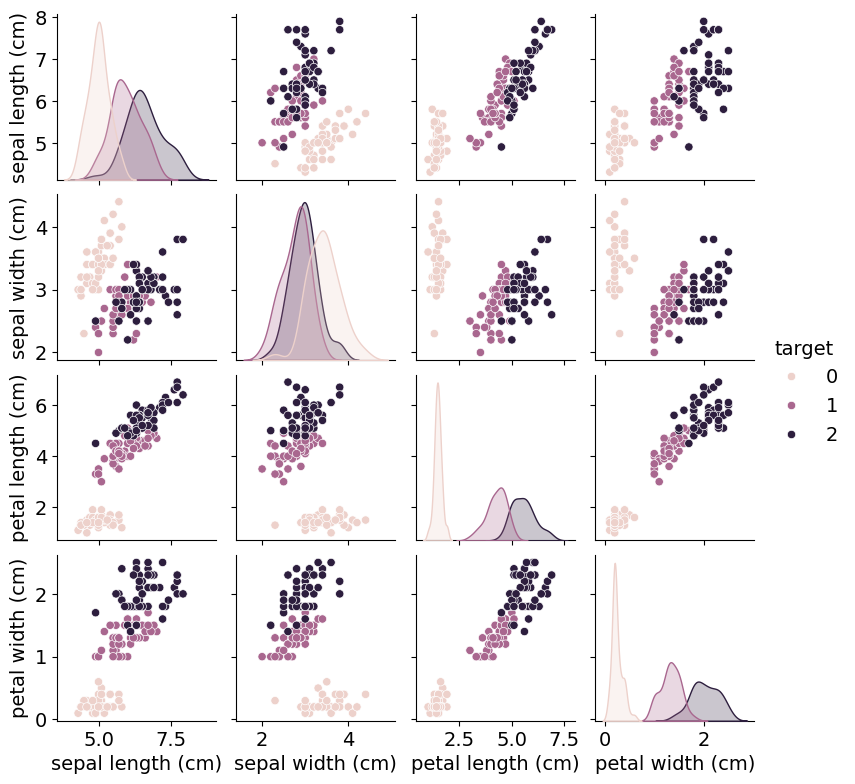

In [6]:
sns.pairplot(iris, hue='target', size=2, aspect=1)

<ipython-input-7-f04f987434a5>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(iris, alpha = 0.2, ax = ax)


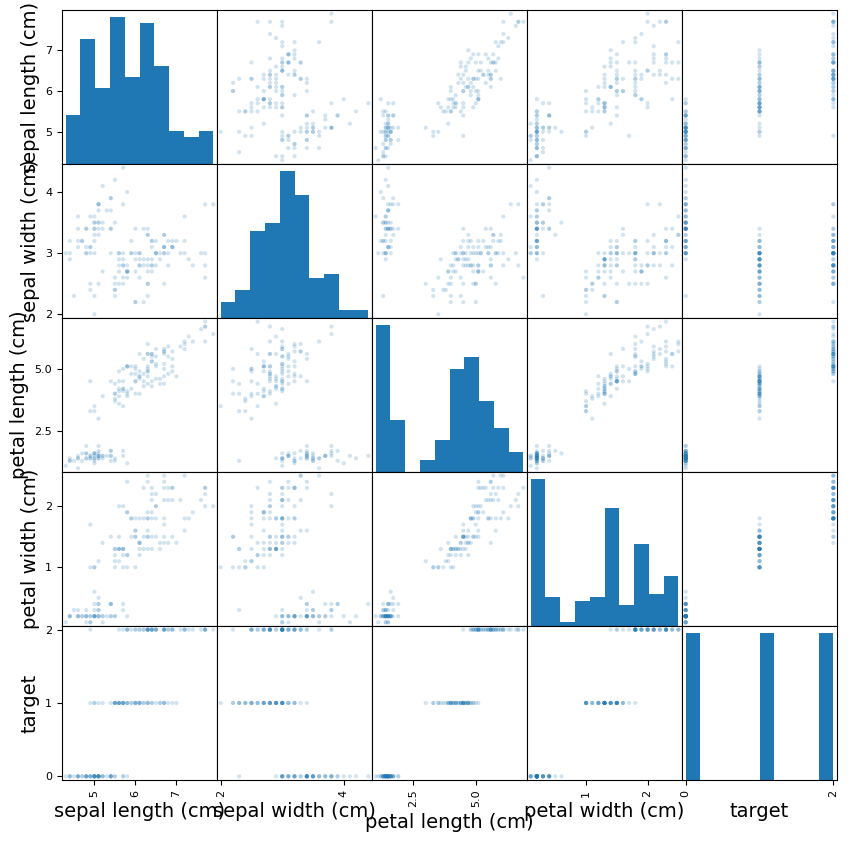

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
pd.plotting.scatter_matrix(iris, alpha = 0.2, ax = ax)
plt.show()

# 3 Decision Tree

- https://adityashrm21.github.io/Decision-Trees/
- https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952
- https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/


## 3.1 Preparing for data

- [play_tennis.csv on Kaggle](https://www.kaggle.com/fredericobreno/play-tennis)
- [Whole Dataset](https://www.dropbox.com/sh/akavld1drqe82cu/AACYH2HFakNvZxVXgjX8c1paa?dl=0)

### 3.1.1  Fetching dataset(s)

In [ ]:
#連結失效
# fetch_file_via_requests(
#     DropboxLink('ebig1xg3nyf81xf', 'play_tennis.csv'), data_dir
# )
# fetch_file_via_requests(
#     DropboxLink('o8ca1x17f0b3anu', 'diabetes.csv'), data_dir
# )
# fetch_file_via_requests(
#     DropboxLink('ftrg7nb5dz7bb5a', 'vertebrate.csv'), data_dir
# )

'/content/drive/My Drive/adventures/tree/vertebrate.csv'

In [11]:
PLAY_TENNIS = '1184U9o08LjtYYWbiD5aeZ3tdfOa8AfGV'
DIABETES = '18OCvLcn4XYJYxL5Jt6UwPVqoYEilm176'
VERTEBRATE = '1iopmosozcWu9pFya179aJQVOfeA1O_TB'

fetch_gdrive_file(PLAY_TENNIS, os.path.join(data_dir, 'play_tennis.csv'))
fetch_gdrive_file(DIABETES, os.path.join(data_dir, 'diabetes.csv'))
fetch_gdrive_file(VERTEBRATE, os.path.join(data_dir, 'vertebrate.csv'))

Downloading...
From: https://drive.google.com/uc?id=1184U9o08LjtYYWbiD5aeZ3tdfOa8AfGV
To: /content/drive/My Drive/adventures/tree/play_tennis.csv
100%|██████████| 470/470 [00:00<00:00, 1.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=18OCvLcn4XYJYxL5Jt6UwPVqoYEilm176
To: /content/drive/My Drive/adventures/tree/diabetes.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 42.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iopmosozcWu9pFya179aJQVOfeA1O_TB
To: /content/drive/My Drive/adventures/tree/vertebrate.csv
100%|██████████| 929/929 [00:00<00:00, 3.26MB/s]


### 3.1.2 load_iris
- [UCI repository](https://archive.ics.uci.edu/ml/datasets/iris)
- [sklearn dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

## 3.2 sklearn DecisionTreeClassifier()

### 3.3.1 Play Tennis

In [12]:
from sklearn.tree import DecisionTreeClassifier

tennis_path = os.path.join(data_dir, 'play_tennis.csv')

df = pd.read_csv(tennis_path)

df.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [13]:
df.columns[1:-1].tolist()

['outlook', 'temp', 'humidity', 'wind']

In [14]:
clf = DecisionTreeClassifier()
weather_features = df.columns[1:-1].tolist()
# clf.fit(df.drop(['play'], axis=1), df.play )

# one hot encoding
df2 = pd.get_dummies(df, columns = weather_features)

X_tennis = df2.drop(['day', 'play'], axis = 1)
y_tennis = df2.play
X_tennis

,outlook_Overcast,outlook_Rain,outlook_Sunny,temp_Cool,temp_Hot,temp_Mild,humidity_High,humidity_Normal,wind_Strong,wind_Weak
0,False,False,True,False,True,False,True,False,False,True
1,False,False,True,False,True,False,True,False,True,False
2,True,False,False,False,True,False,True,False,False,True
3,False,True,False,False,False,True,True,False,False,True
4,False,True,False,True,False,False,False,True,False,True
5,False,True,False,True,False,False,False,True,True,False
6,True,False,False,True,False,False,False,True,True,False
7,False,False,True,False,False,True,True,False,False,True
8,False,False,True,True,False,False,False,True,False,True
9,False,True,False,False,False,True,False,True,False,True


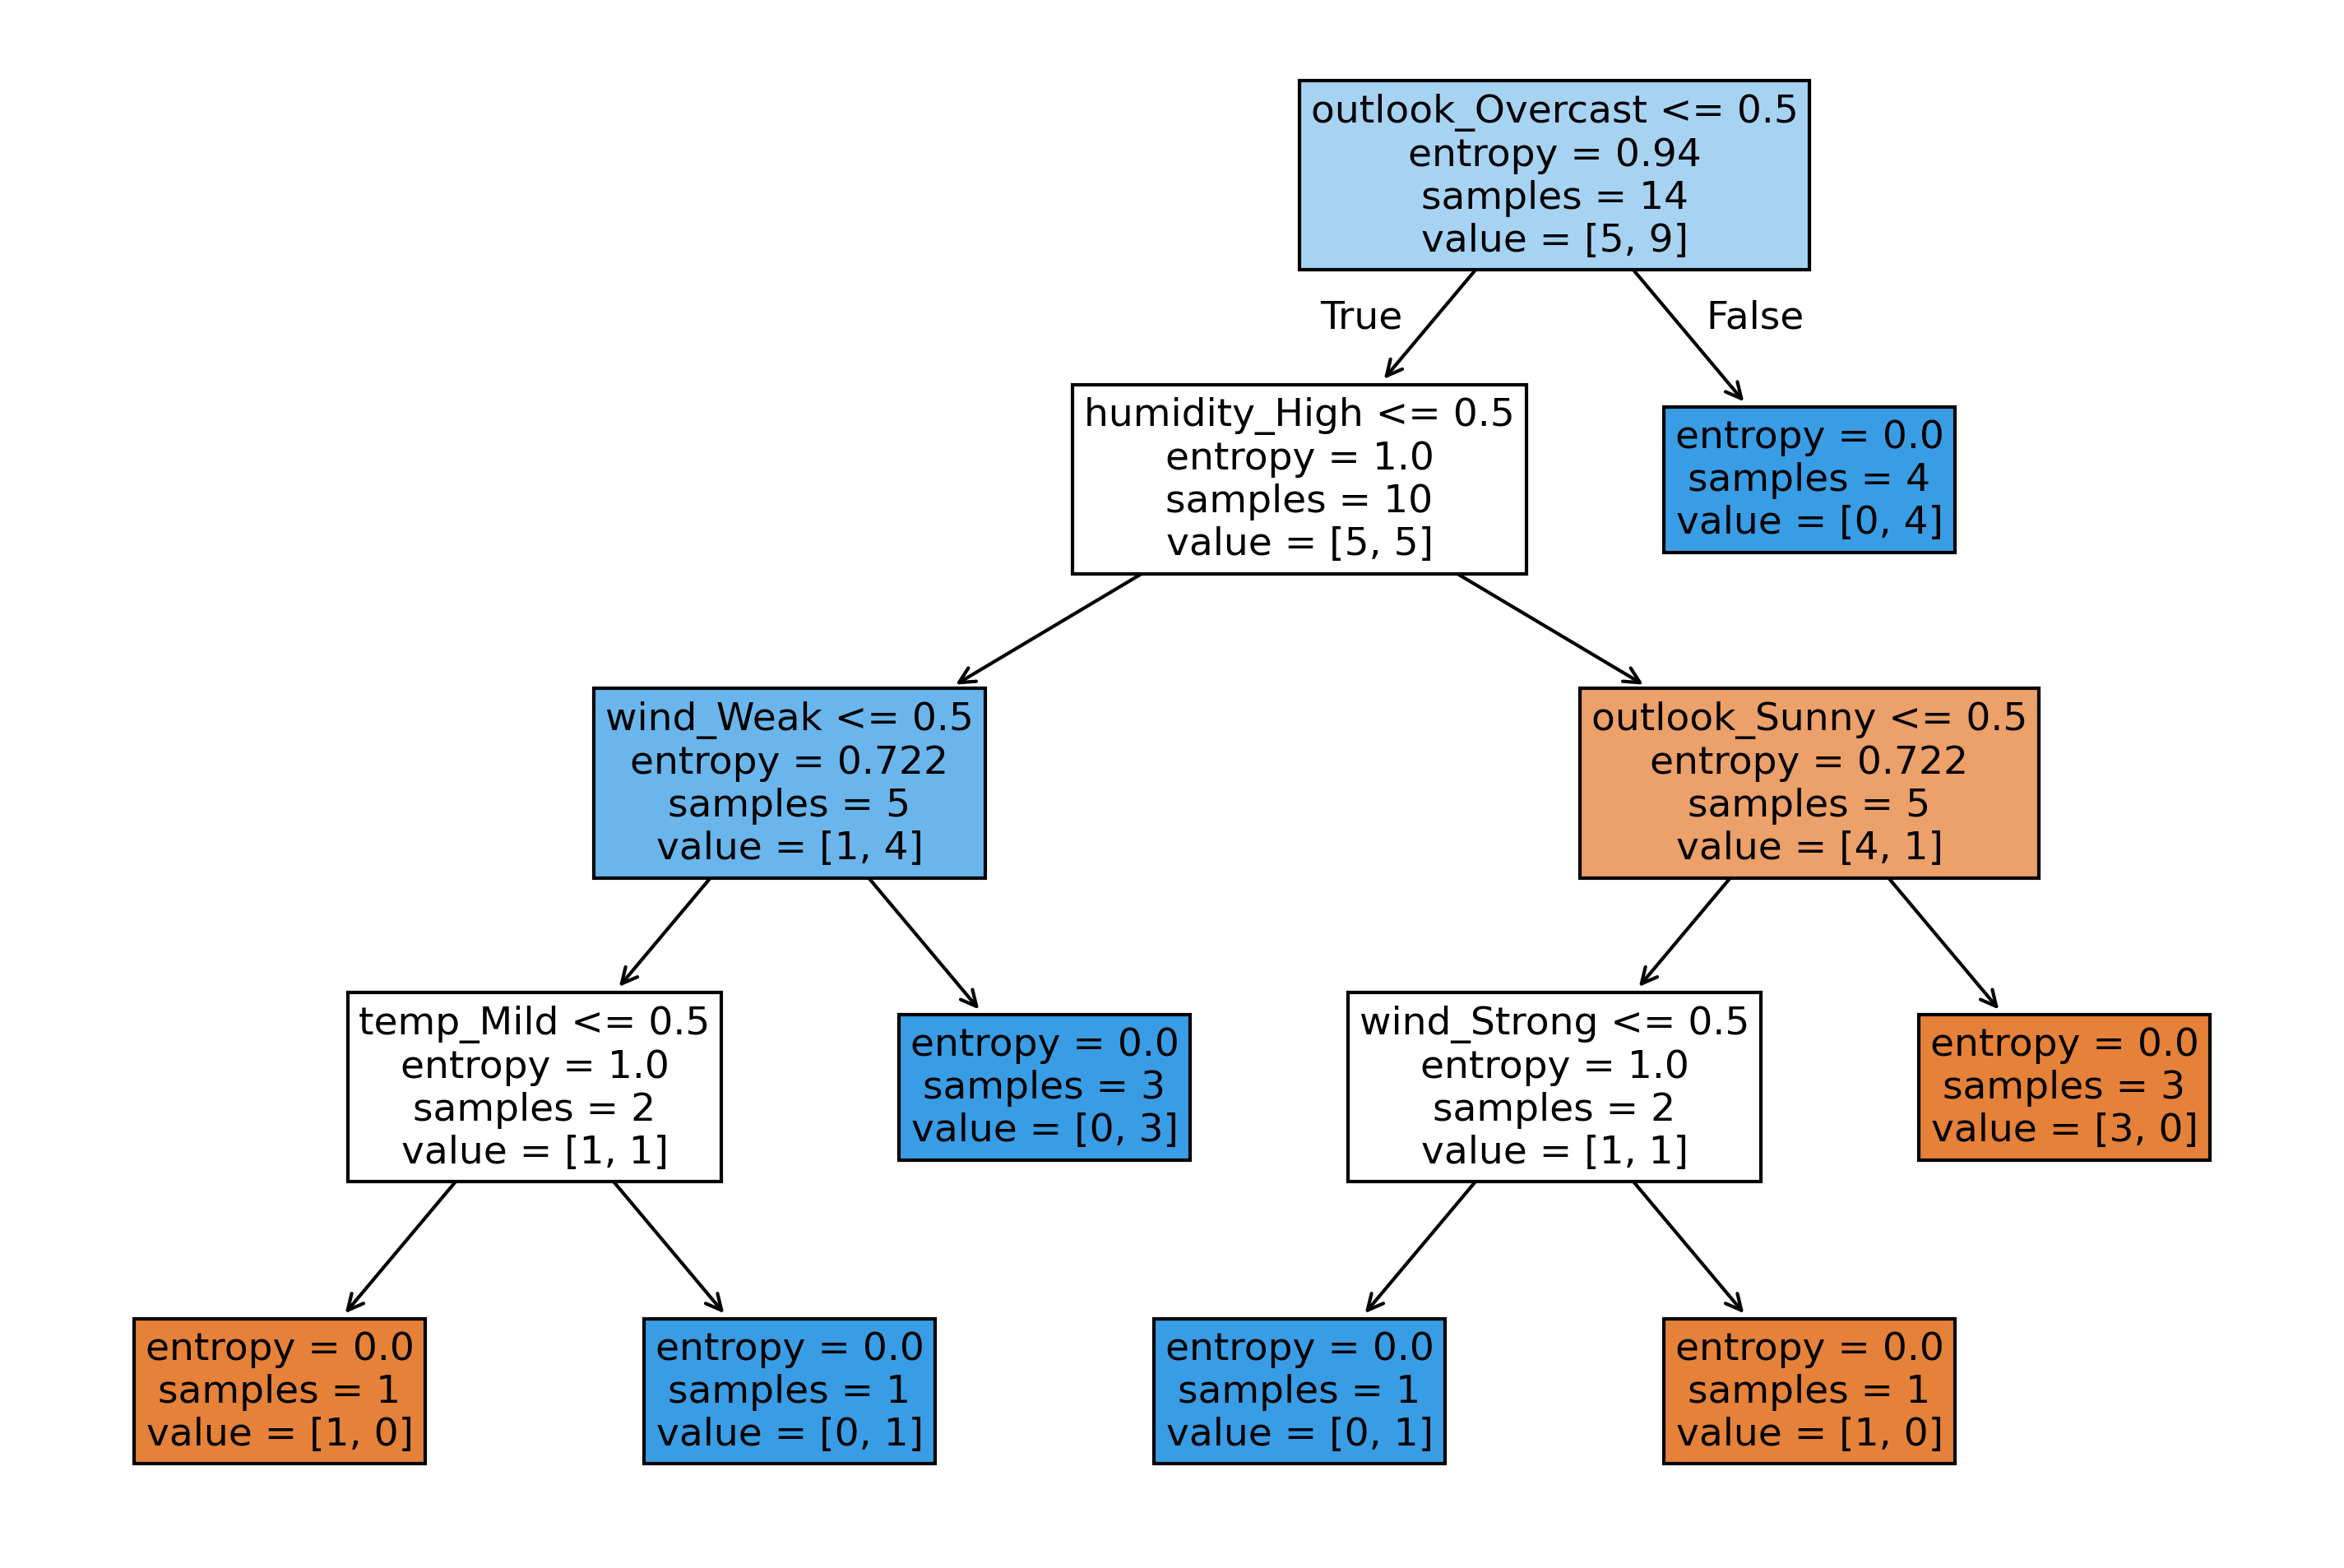

In [18]:
from sklearn.tree import plot_tree, DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_tennis, y_tennis)

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

plot_tree(clf, filled=True, feature_names=df2.columns[2:], ax=ax)

fig.savefig(figure_dir + 'tennis plot_tree demo')
plt.show()

### 3.3.2 Iris

### 3.3.3 Indians Diabetes

 - [Visualizing Decision Trees with Python (Scikit-learn, Graphviz, Matplotlib)](https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc)

In [19]:
%%time

from sklearn.tree import DecisionTreeClassifier

dia_path = os.path.join(data_dir, 'diabetes.csv')

dia = pd.read_csv(dia_path)

display(dia)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


CPU times: user 15.9 ms, sys: 969 µs, total: 16.9 ms
Wall time: 19.9 ms


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_dia = dia.drop(['Outcome'], axis = 1)
y_dia = dia.Outcome

x_train, x_test, y_train, y_test  = \
    train_test_split(X_dia, y_dia, test_size=0.2)  # 分割訓練集及測試集

# choose criterion = 'gini' or 'entropy'
dt = DecisionTreeClassifier(criterion='gini')   # 創建實例（instance）

dt.fit(x_train, y_train)        # fit data

yhat = dt.predict(x_test)       # 預測

print(f'Score of Model = {dt.score(x_test, y_test):.4f}' ) # mean accuracy

Score of Model = 0.6299


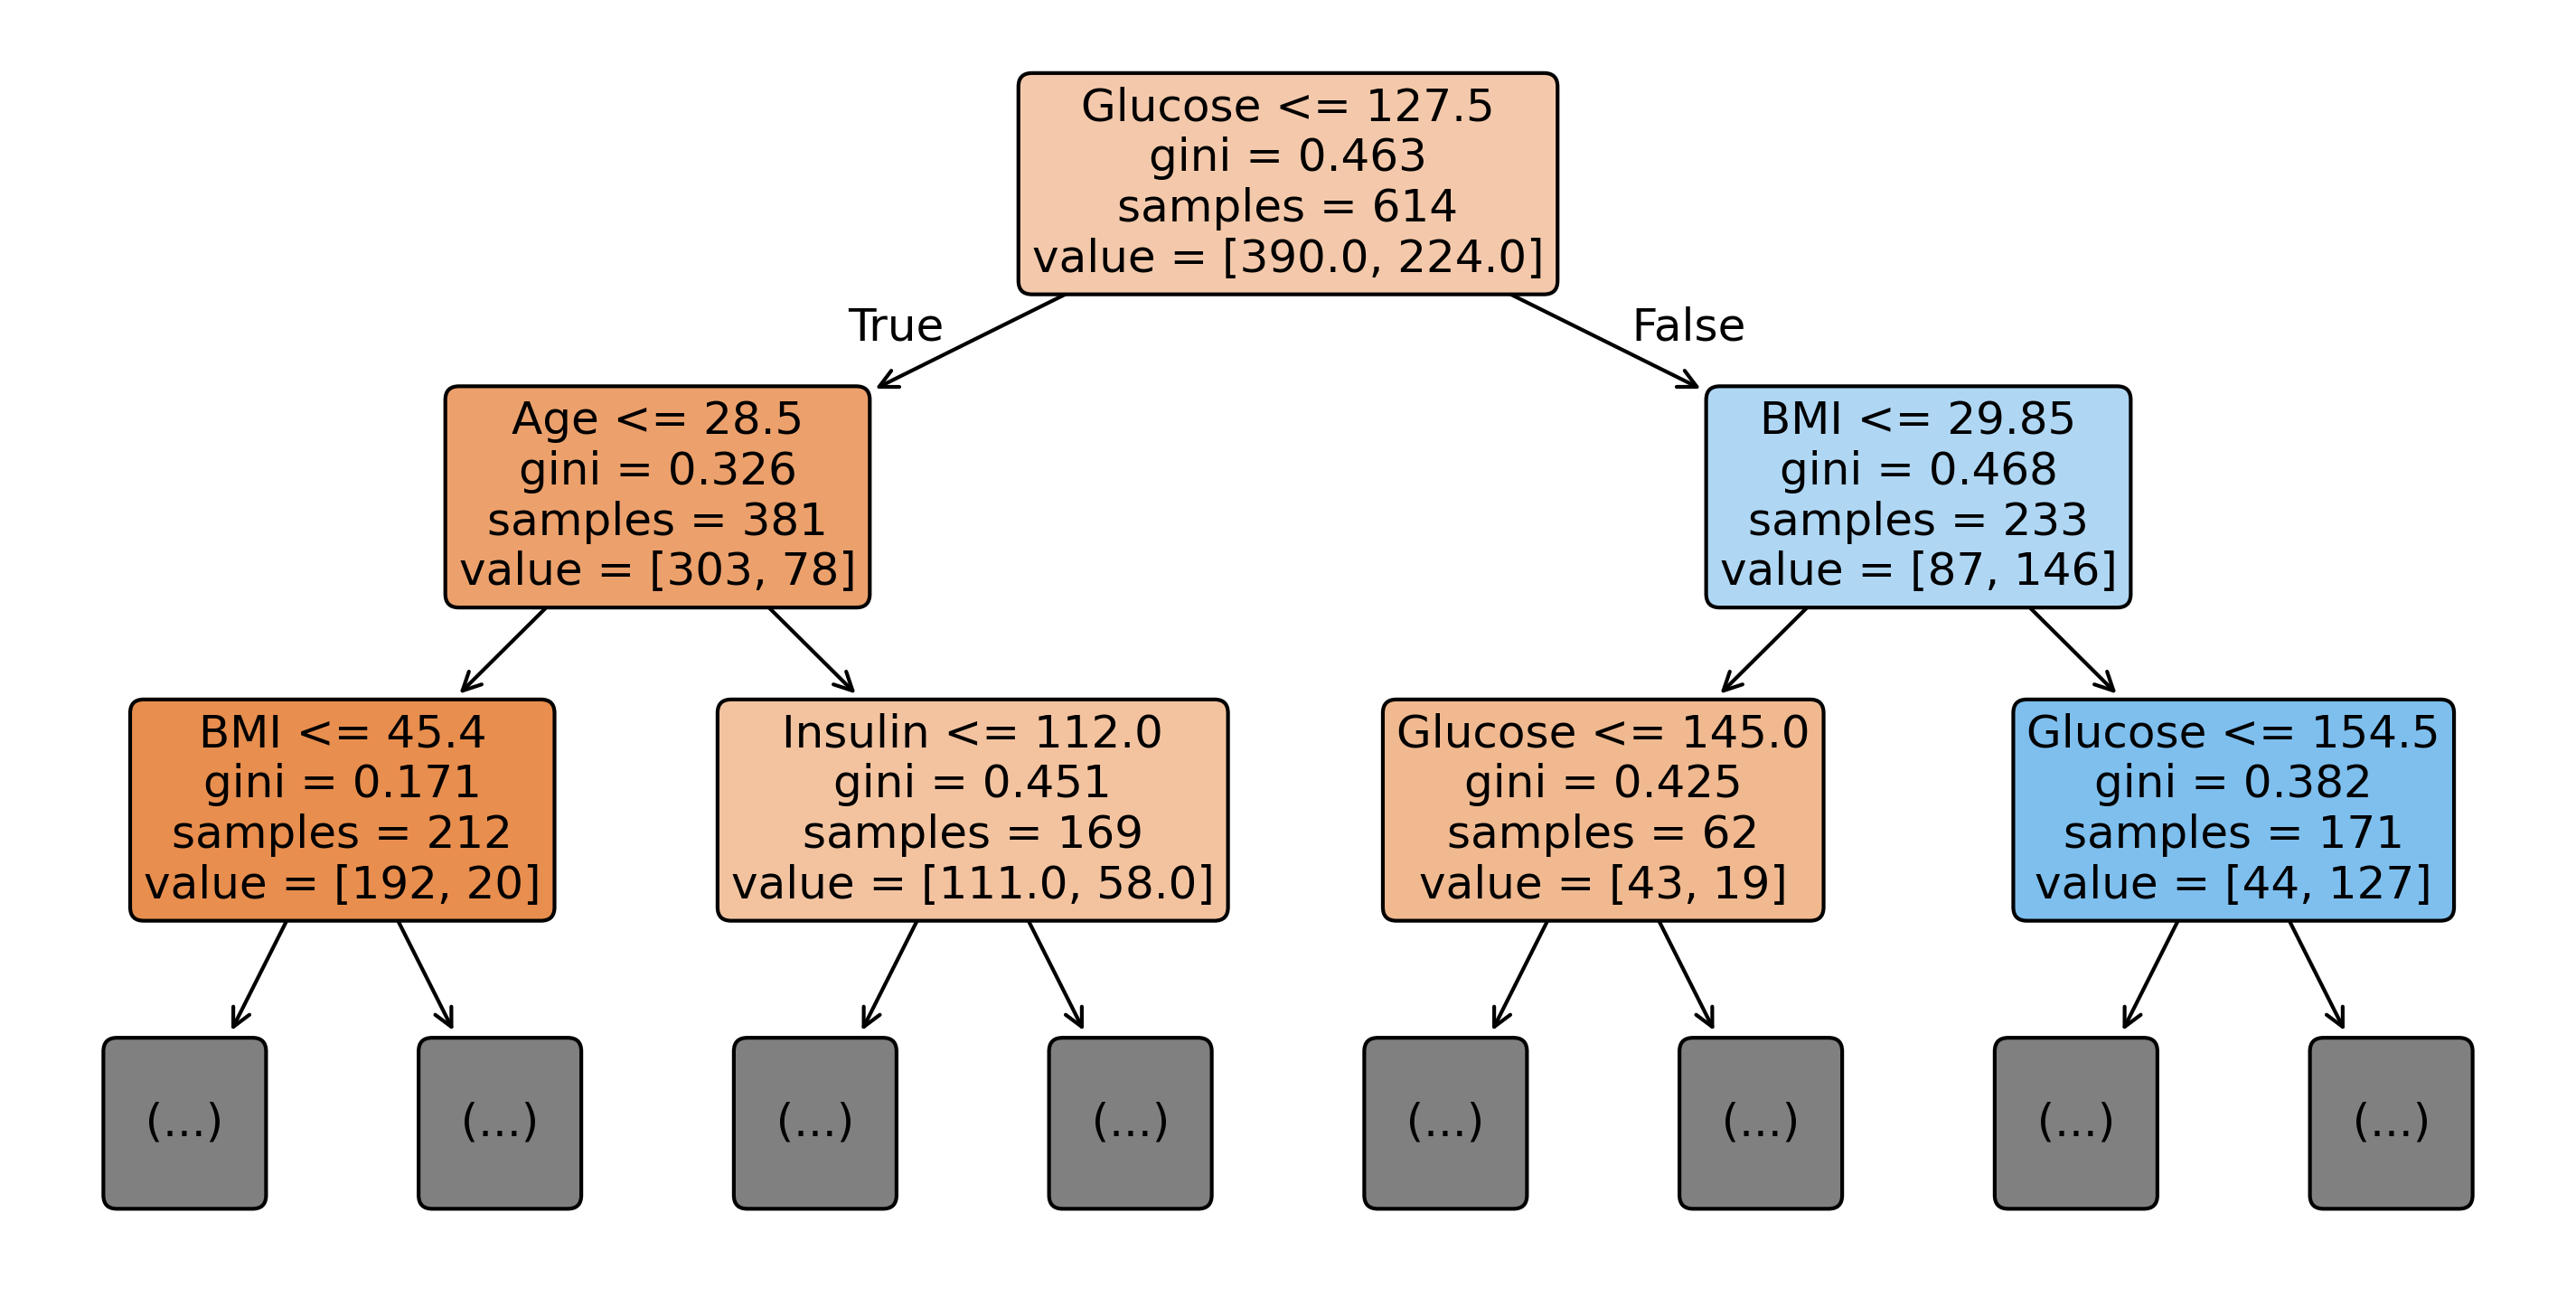

In [21]:
from sklearn.tree import plot_tree

fig,ax = plt.subplots(figsize=(12, 6), dpi=300)

plot_tree(dt, feature_names=X_dia.columns, fontsize=12,
          max_depth=2, rounded=True, filled=True, ax=ax)
plt.show()

## 3.3 Draw the tree

### plot_tree

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier

dia_path = os.path.join(data_dir, 'diabetes.csv')
dia = pd.read_csv(dia_path)

X_dia = dia.drop(['Outcome'], axis = 1)
y_dia = dia.Outcome

x_train, x_test, y_train, y_test  = \
    train_test_split(X_dia, y_dia, test_size = 0.2)

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

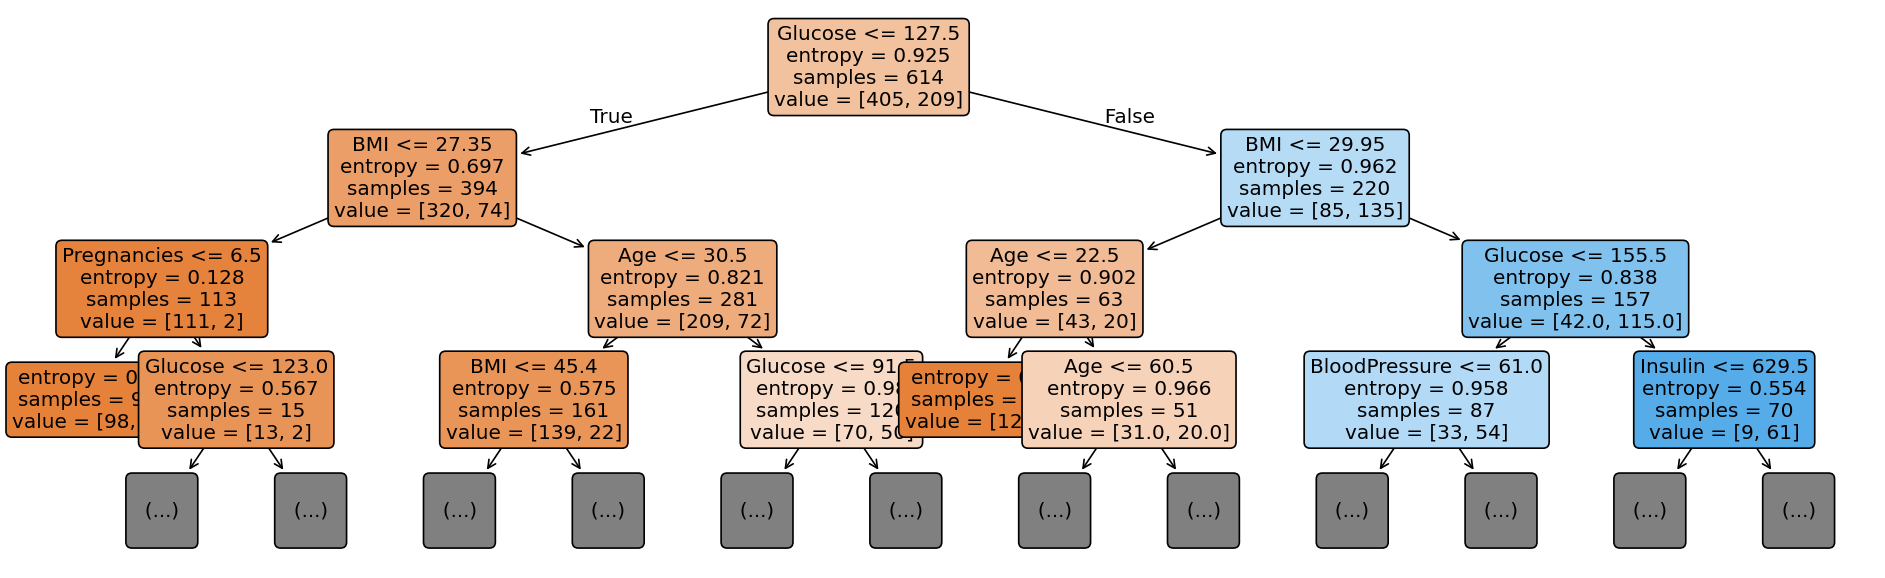

In [23]:
from sklearn.tree import plot_tree

fig,ax = plt.subplots(figsize=(20, 6), dpi=120)
plot_tree(dt, feature_names=X_dia.columns, fontsize=12,
          max_depth=3, rounded=True, filled=True, ax=ax)
plt.savefig(figure_dir + 'pima diabetes plot_tree')
plt.show()

- [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)

### graphviz

- [graphviz.org](https://graphviz.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Graphviz)
- [DOT](https://en.wikipedia.org/wiki/DOT_(graph_description_language))

In [24]:
from sklearn.tree import export_graphviz
import graphviz

def output_tree(model , feature_names = None, format = 'png',
    outname = 'tree'):
    dot_data = export_graphviz(model,
        out_file = None,
        feature_names = feature_names,
        rounded=True, filled=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.format = format
    graph.render(figure_dir + outname)

In [25]:
from sklearn.tree import export_graphviz
import graphviz

# https://graphviz.org/

dot_data = export_graphviz(dt,
    out_file = None,
    feature_names = X_dia.columns,
    rounded=True, filled=True, special_characters=True)
graph = graphviz.Source(dot_data)
# graph
graph.format = 'png'
graph.render(figure_dir + 'graphviz demo')

'/content/drive/My Drive/adventures/figure/tree/graphviz demo.png'

## 3.4 Feature Importances

- [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

決策樹的 feature importance 怎麼算出來的
        Returns
        -------
        feature_importances_ : ndarray of shape (n_features,)
            Normalized total reduction of criteria by feature
            (Gini importance).

<Axes: >

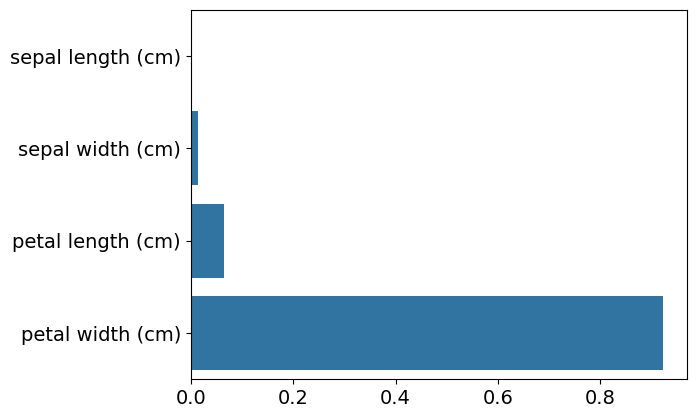

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

data = load_iris()
X,y = data['data'], data['target']

dt = DecisionTreeClassifier()
dt.fit(X, y)

dt.feature_importances_
sns.barplot(x=dt.feature_importances_,y=data['feature_names'])



## 3.5 Decision Boundaries

- [mlxtend Plotting Decision Regions](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-5-evaluating-classifier-behavior-on-non-linear-problems)
- [YB DecisionBoundaries Vizualizer](https://www.scikit-yb.org/en/latest/api/contrib/boundaries.html)

In [27]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):

    if ax is None:
        fig,ax = plt.subplots(figsize=(8,6), dpi=200)
    else:
        ax=ax
    # ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap=cmap, edgecolor = 'k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z,
               cmap="Pastel1", alpha = 0.2)
    ax.contour(xx,yy, Z,
                linewidths=1, colors='k', alpha = 0.3)
    ax.set(xlim=xlim, ylim=ylim)


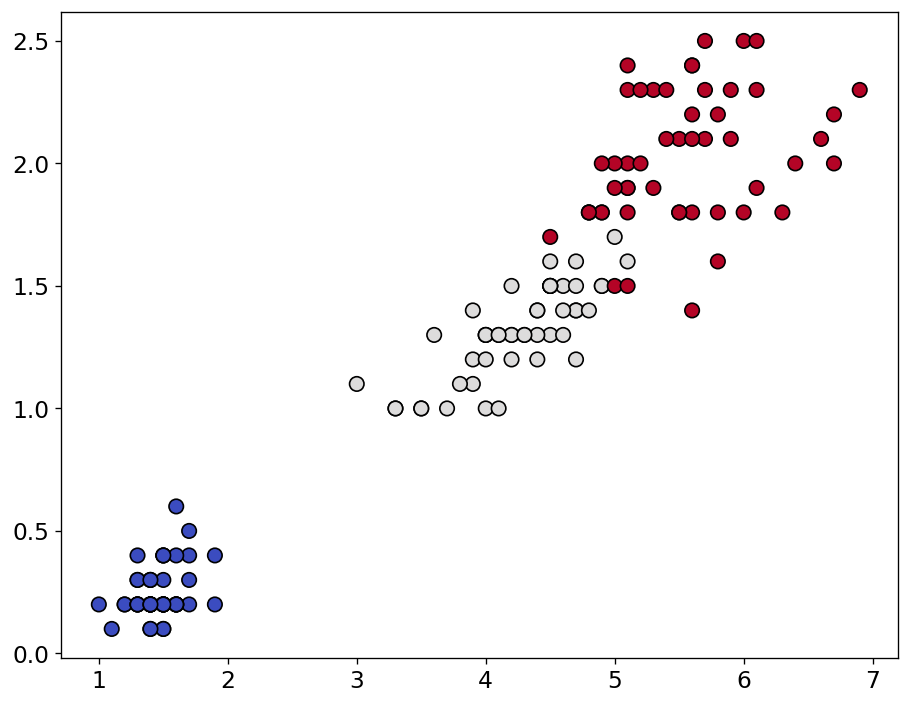

In [28]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

data = load_iris()
X_iris, y_iris = data['data'][:,[2,3]], data['target']

dt = DecisionTreeClassifier()
dt.fit(X_iris, y_iris)
y_hat = dt.predict(X_iris)

plt.figure(figsize=(9,7), dpi=120)
plt.scatter(X_iris[:, 0], X_iris[:, 1], s = 75,
    c=y_hat, cmap='coolwarm', edgecolor='k')

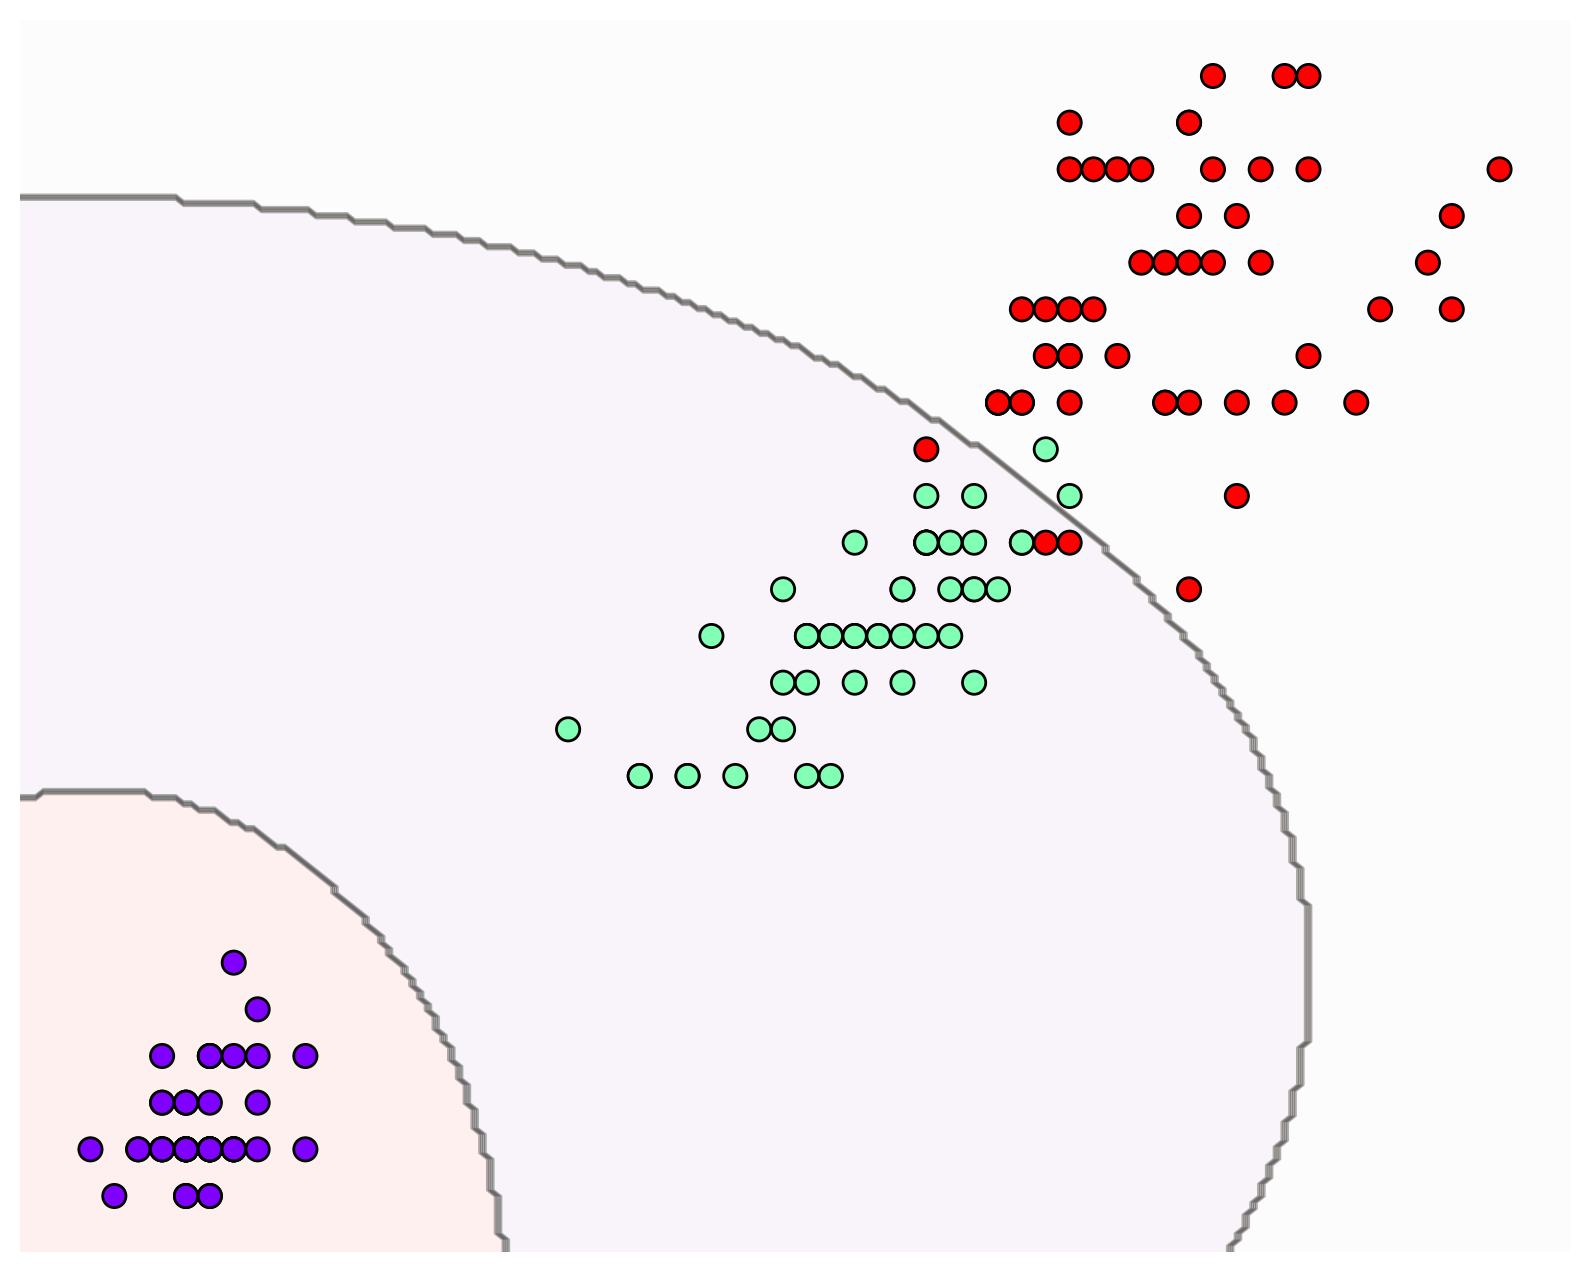

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

fig,ax = plt.subplots(figsize=(10, 8), dpi=200)
visualize_classifier(model, X_iris, y_iris, ax=ax)

## Gini vs. Information Gain

Text(0, 0.5, 'Impurity Index')

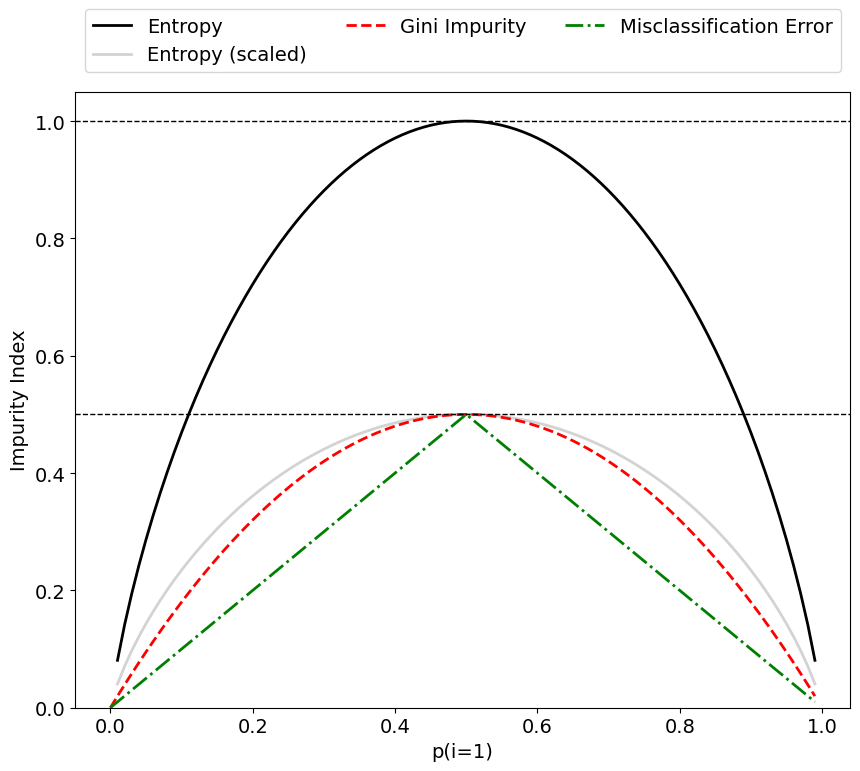

In [30]:
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]

sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                   ['Entropy', 'Entropy (scaled)',
                   'Gini Impurity',
                   'Misclassification Error'],
                   ['-', '-', '--', '-.'],
                   ['black', 'lightgray',
                      'red', 'green', 'cyan']):
     line = ax.plot(x, i, label=lab,
                    linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.05])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
# output_fig('gini and ig')



# 4 Regression Tree

## Hitters.CSV

- [R Documentation](https://www.rdocumentation.org/packages/ISLR/versions/1.2/topics/Hitters)
- [Kaggle Source](https://www.kaggle.com/floser/hitters)
- [Linear Model selection - Hitters dataset](http://rstudio-pubs-static.s3.amazonaws.com/454303_2010275851a046df8796eb2e0da369b5.html)

**LEAGUE** : Player’s league

**ATBAT** : Times at Bat: Number of official plate appearances by a hitter. It counts as an official at-bat as long as the batter does not walk, sacrifice, get hit by a pitch or reach base due to catcher’s interference.

**HITS** : Hits

**HMRUN** : Home Runs

**RUNS** : The number of runs scored by a player. A run is scored by an offensive player who advances from batter to runner and touches first, second, third and home base in that order without being put out.

**RBI** Runs Batted In: A hitter earns a run batted in when he drives in a run via a hit, walk, sacrifice (bunt or fly) fielder’s choice, hit- batsman or on an error (when the official scorer rules that the run would have scored anyway).

**WALKS** : Walks: A walk - base on balls is an award of first base granted to a batter who receives four pitches outside the strike zone.

**YEARS** : Years in the Major Leagues. As far as we can tell, this counts all years a player has actually played in the Major Leagues, not necessarily consectutive. Rookie contracts - 4Yrs.

**CATBAT** : Career Times at Bat

**<u><font color='brown'>CHITS</font></u>** : Career Hits

**CHMRUN** : Career Home Runs

**CRUNS** : Career Runs Scored

**CRBI** : Career Runs Batted In POSITION Player’s position(s). See list of codes used below under Coding for some of the variables. (You are free to recode these as you see fit.)

**PUTOUTS** : Put Outs. A put out is credited when a fielder causes a batter or runner to be, well, put out; e.g., catches the batter’s fly ball, tags a base runner out before he reaches the base, etc.

**ASSISTS** : An assist is credited when a fielder assists in a play causing a player to be put out; e.g.,

**ERRORS** : Errors

**<font color='brown'>SALARY</font>** : 1987 Annual salary on opening day (in 1000$) - Variable of Interest!

**BATAVG** : Batting Average, calculated as 1000*(HITS/ATBAT)

**CBATAVG** : Career Batting Average, calculated as 1000*(HITSC/ATBATC)

**ROOKIE** : Boolean Variable; 1 if years < 4; 0 otherwise

In [ ]:
#連結失效
# fetch_file_via_requests(
#     DropboxLink('qguf5p681ixky2l', 'hitters.csv'), data_dir )

In [31]:
HITTERS = '1OOub4nc5PXEQsleREMH_p9NcSnqdQAKd'

fetch_gdrive_file(HITTERS, os.path.join(data_dir, 'hitters.csv'))

Downloading...
From: https://drive.google.com/uc?id=1OOub4nc5PXEQsleREMH_p9NcSnqdQAKd
To: /content/drive/My Drive/adventures/tree/hitters.csv
100%|██████████| 27.7k/27.7k [00:00<00:00, 44.6MB/s]


In [32]:
hit = pd.read_csv(os.path.join(data_dir, 'hitters.csv'))
hit.drop(['Unnamed: 0'], axis = 1, inplace=True)
hit.dropna(inplace=True)
hit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

<ipython-input-33-86db74030ecc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=hit.Salary)


<Axes: ylabel='Density'>

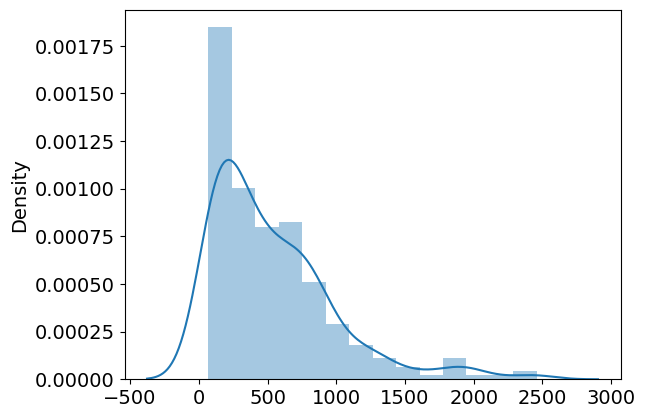

In [33]:
sns.distplot(x=hit.Salary)

<ipython-input-34-74fa02193f46>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=np.log(hit.Salary))


<Axes: ylabel='Density'>

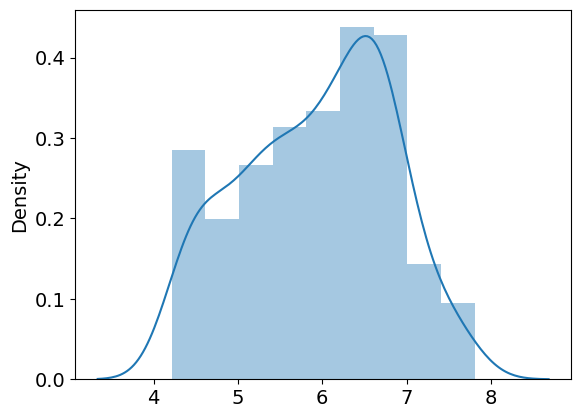

In [34]:
sns.distplot(x=np.log(hit.Salary))

In [35]:
selected_features = ['Hits', 'HmRuns', 'Runs', 'RBI',
    'Walks', 'Years', 'Errors']

X = hit.filter(selected_features).copy()
y = np.log(hit.Salary) # log tranformation


In [36]:
X

,Hits,Runs,RBI,Walks,Years,Errors
1,81,24,38,39,14,10
2,130,66,72,76,3,14
3,141,65,78,37,11,3
4,87,39,42,30,2,4
5,169,74,51,35,11,25
...,...,...,...,...,...,...
317,127,65,48,37,5,3
318,136,76,50,94,12,20
319,126,61,43,52,6,7
320,144,85,60,78,8,12


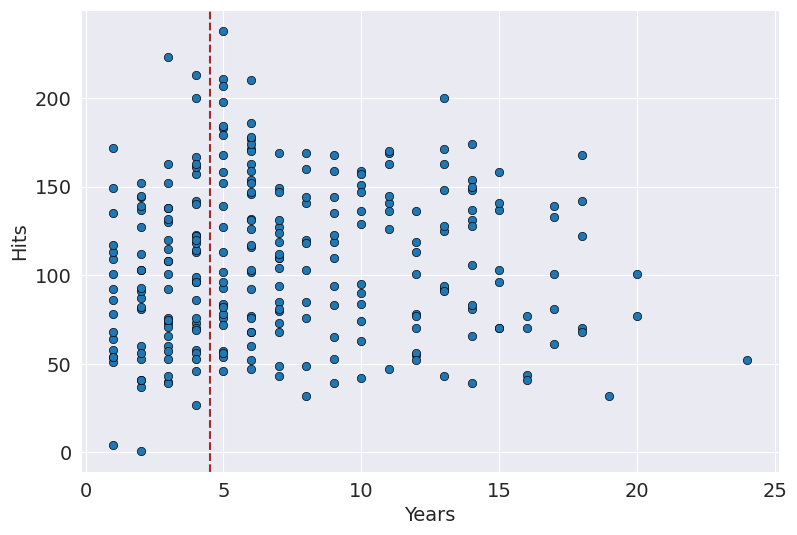

In [37]:
ax =start_plot(figsize=(9, 6), style='darkgrid')
sns.scatterplot(x='Years', y='Hits', edgecolor='k', data=X, ax=ax)
ax.axvline(x=4.5, ls='--', c='brown')

In [38]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor()  # max_depth default = None

regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)


DecisionTreeRegressor()

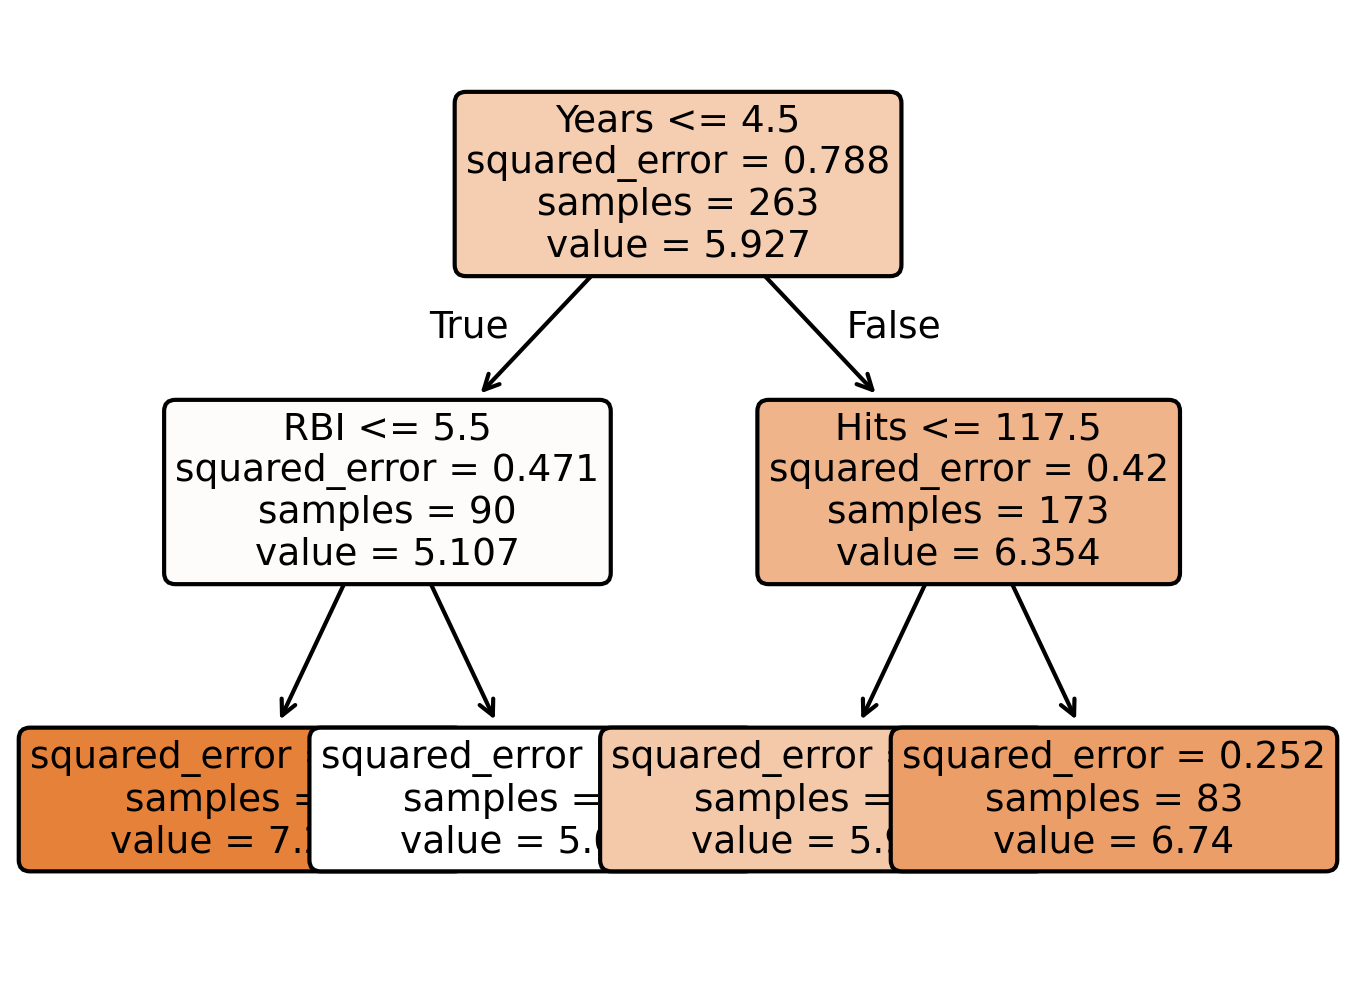

In [39]:
from sklearn.tree import plot_tree

fig,ax = plt.subplots(figsize=(5, 4), dpi=300)
plot_tree(regr_1, feature_names=X.columns, fontsize=9,
          filled=True, rounded=True, ax=ax)
# fig.savefig()
plt.show()


In [40]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(regr_1,
    out_file = None,
    feature_names=X.columns, rounded=True,
    filled=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph
graph.format = 'png'
# graph.render(figure_dir + 'hitters full')
graph.render('hitters_1')

'hitters_1.png'

## Regularization

- $y = 4\times (x-0.5)^2 + \frac{randn(m,1)}{10}$

In [41]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

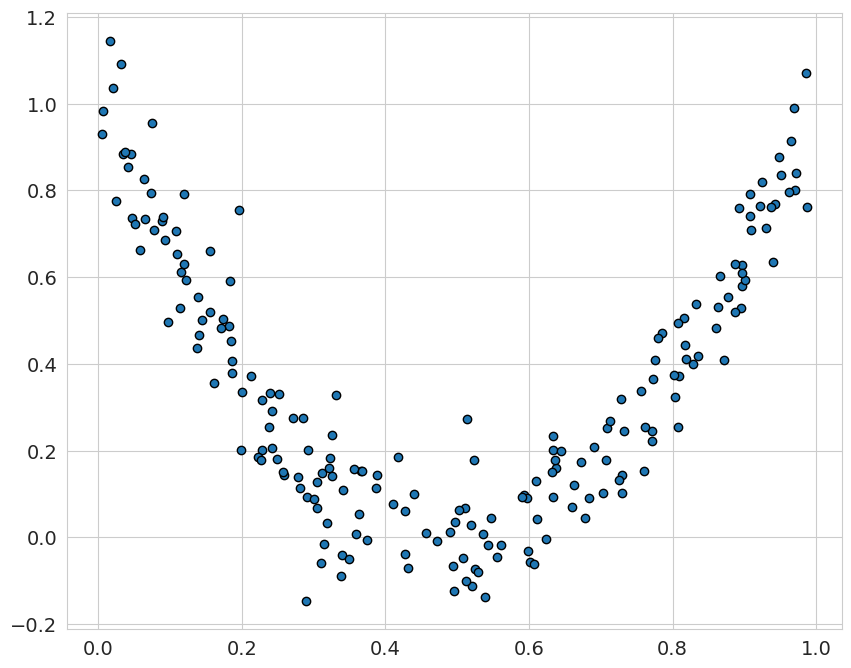

In [42]:
ax = start_plot()
ax.scatter(X,y, edgecolor = 'k')

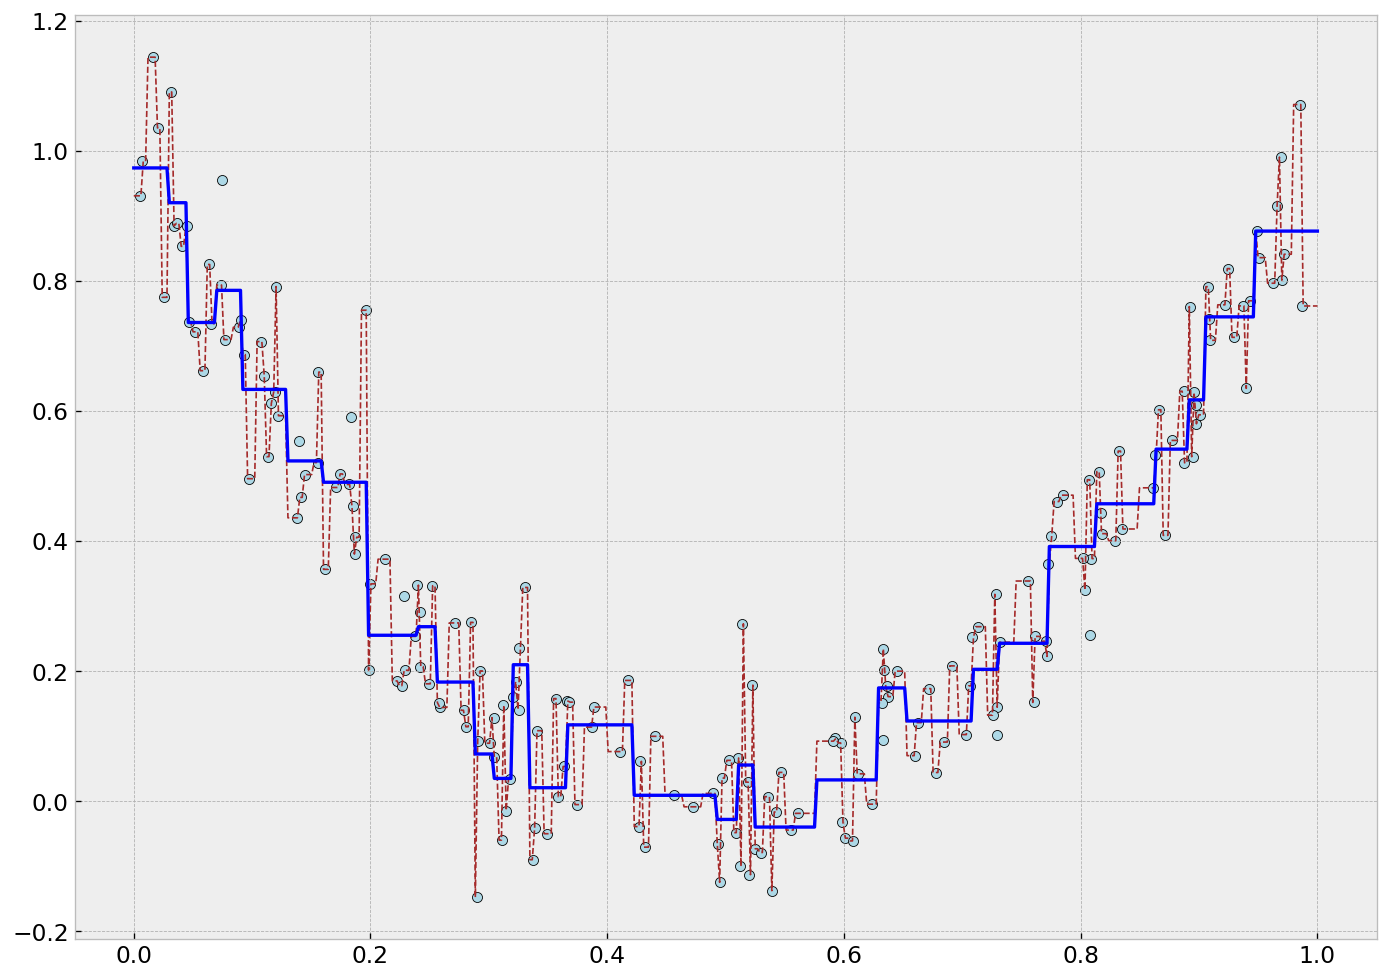

In [43]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor()
regr_2 = DecisionTreeRegressor(min_samples_leaf=5)

regr_1.fit(X, y)
regr_2.fit(X, y)

X1 = np.linspace(0,1,500).reshape(-1, 1)
y_pred1 = regr_1.predict(X1)  # x_test
y_pred2 = regr_2.predict(X1)

with plt.style.context('bmh'):
    _, ax = plt.subplots(figsize=(14, 10), dpi=120)
    ax.scatter(X, y, c = 'lightblue', edgecolor='k',
        label = 'training data')
    ax.plot(X1, y_pred1, c = 'brown', ls = '--', lw = 1)
    ax.plot(X1, y_pred2, c = 'blue', lw = 2)


# 5 Bank Markering Data

- [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- [Bank Marketing Short Version](https://www.kaggle.com/rouseguy/bankbalanced)
- [Bank Marketing Long Version](https://www.kaggle.com/henriqueyamahata/bank-marketing)



1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
-----------
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
-----------------
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
-----------
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)



In [44]:
#連結失效
# fetch_file_via_requests(
#     DropboxLink('ahacs515a01ev8r', 'bank-additional-full.csv'), data_dir )
# fetch_file_via_requests(
#     DropboxLink('iw4jhthgf3ljk9c', 'bank.csv'), data_dir )

## Read data

In [45]:
BANK_ADDITIONAL_FULL = '18FFb7IJvVP2-whtQk5rw685X2IJVIMbj'

fetch_gdrive_file(BANK_ADDITIONAL_FULL, os.path.join(data_dir, 'bank-additional-full.csv'))

Downloading...
From: https://drive.google.com/uc?id=18FFb7IJvVP2-whtQk5rw685X2IJVIMbj
To: /content/drive/My Drive/adventures/tree/bank-additional-full.csv
100%|██████████| 5.83M/5.83M [00:00<00:00, 22.4MB/s]


In [46]:
bank_csv = os.path.join(data_dir, 'bank-additional-full.csv')
bank = pd.read_csv(bank_csv, sep=';')


In [47]:
bank.y.unique()

array(['no', 'yes'], dtype=object)

In [48]:
bank.y = bank.y.map({'yes':1, 'no':0})
bank.rename(columns={'y':'result'}, inplace=True)
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


## EDA

In [50]:
corr = bank.corr()
fig,ax = plt.subplots(figsize=(10,8), dpi=100)
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.6, ax=ax)

ValueError: could not convert string to float: 'housemaid'

<Axes: xlabel='result', ylabel='count'>

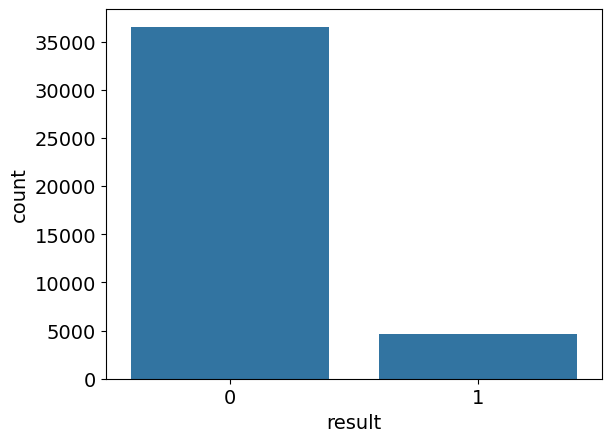

In [51]:
sns.countplot(x='result', data=bank)

In [52]:
bank.groupby(['result']).size()/len(bank)

,0
result,
0,0.887346
1,0.112654


<Axes: xlabel='count', ylabel='education'>

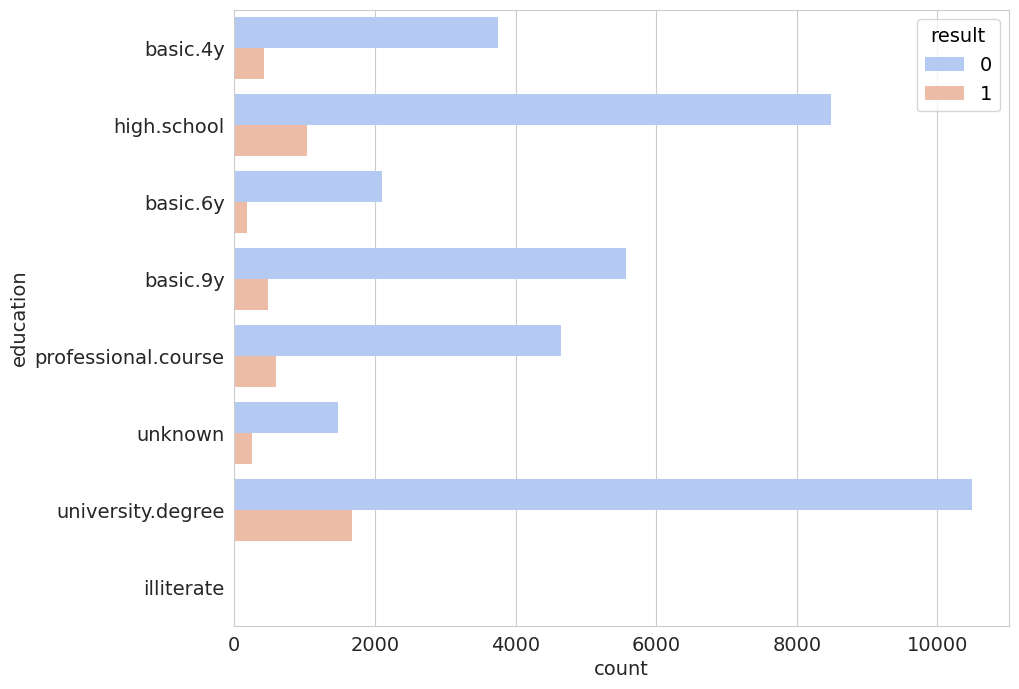

In [53]:
ax = start_plot()
sns.countplot(y='education', hue='result',
              palette='coolwarm', data=bank, ax=ax)


In [54]:
def ratios(to_watch, sub=True):
    a = bank.groupby(['result', to_watch]).size()
    b = bank.groupby([to_watch]).size()
    return a.loc[1]/b

def dig_further(to_watch, orient = 'v'):

    fig,ax = plt.subplots(1,2, figsize=(16, 6),
        # sharey= True if orient=='h' else 'False',
        dpi=120)

    rlist = ratios(to_watch)

    if orient == 'v':
        sns.countplot(x = to_watch, hue = 'result',
            data = bank, ax=ax[0])
        sns.barplot(x=rlist.index, y=rlist.values,
            orient = orient,
            ax=ax[1])
    else:
        sns.countplot(y = to_watch, hue = 'result',
            data = bank, ax=ax[0])
        sns.barplot(y=rlist.index, x=rlist.values,
            orient = orient,
            ax=ax[1])

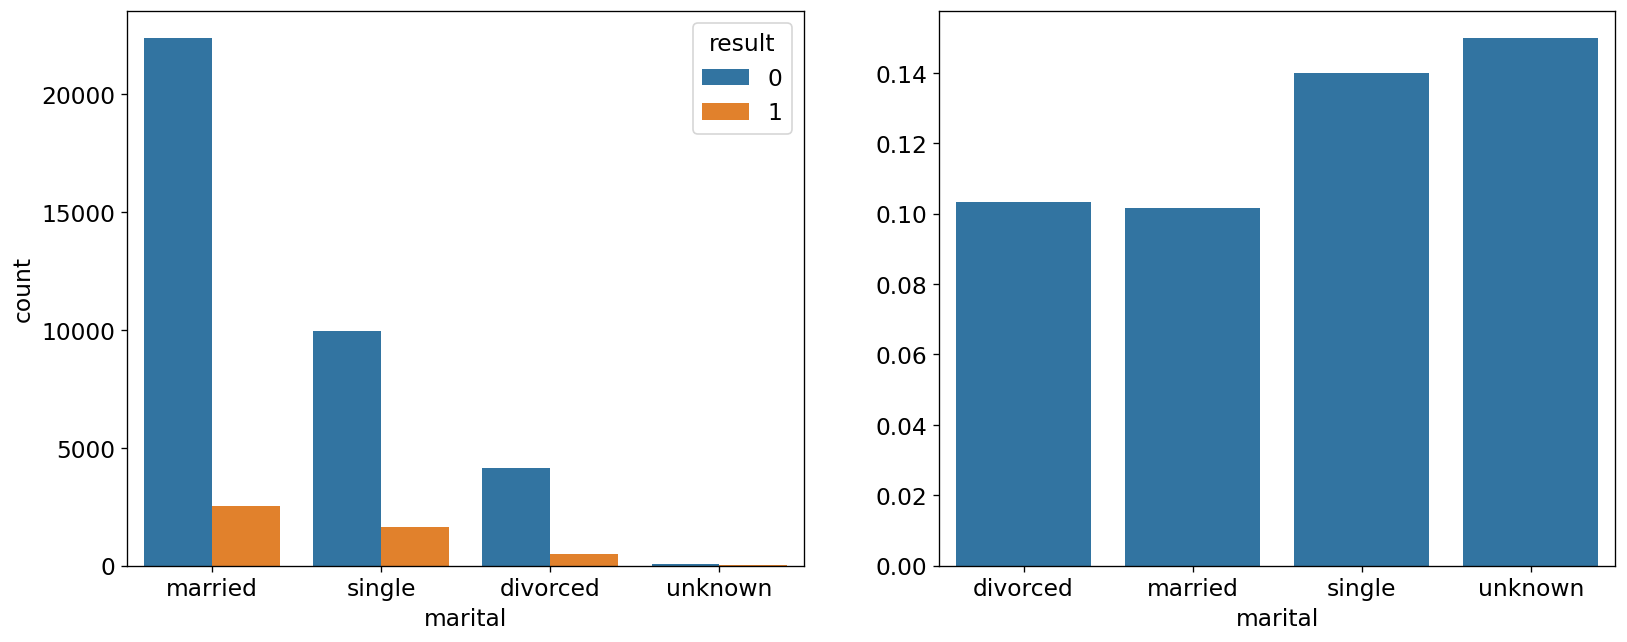

In [55]:
dig_further('marital')

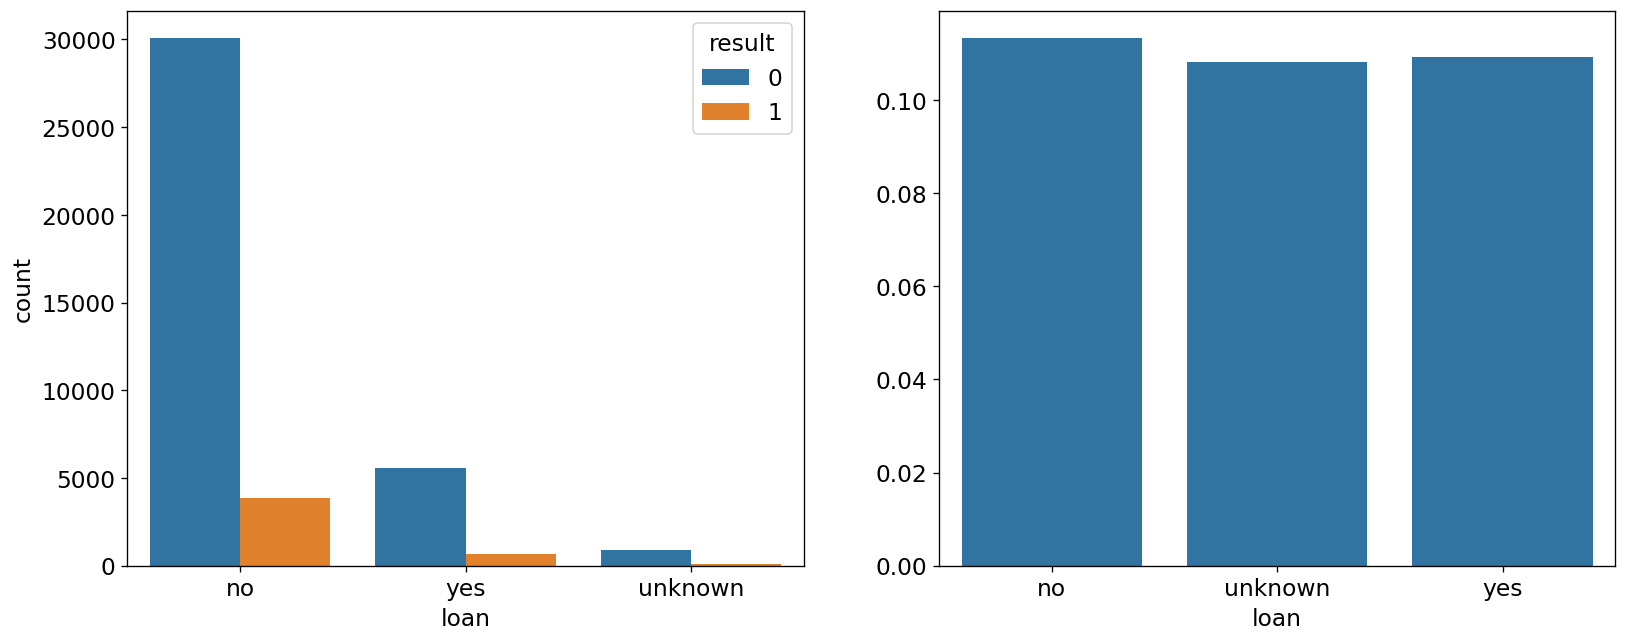

In [56]:
dig_further('loan')

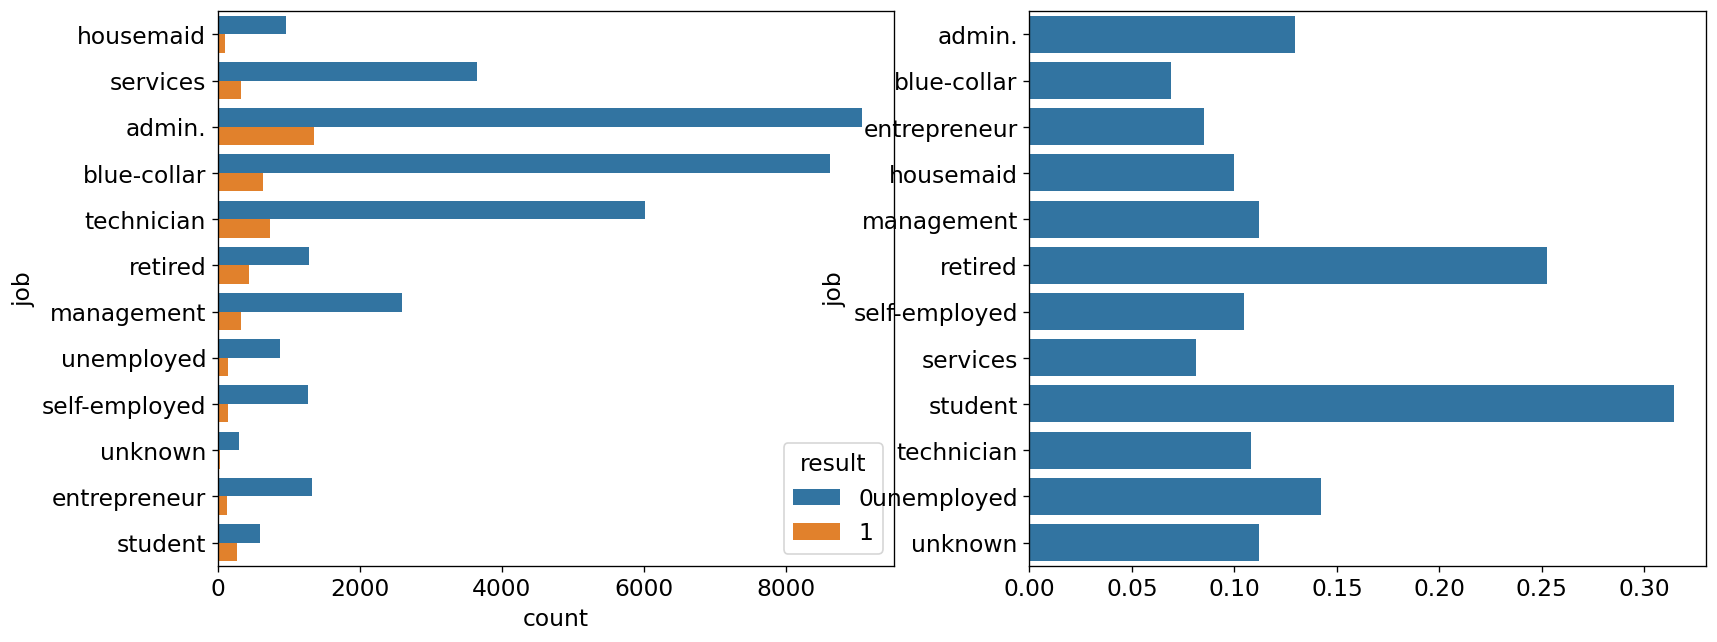

In [57]:
dig_further('job', orient='h')

<Axes: xlabel='result', ylabel='age'>

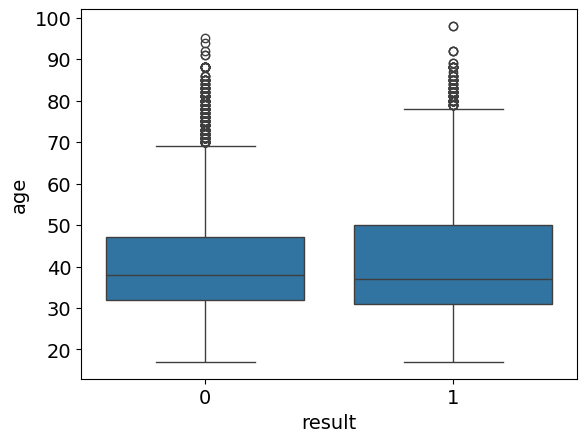

In [58]:
sns.boxplot(x='result', y='age', data=bank)

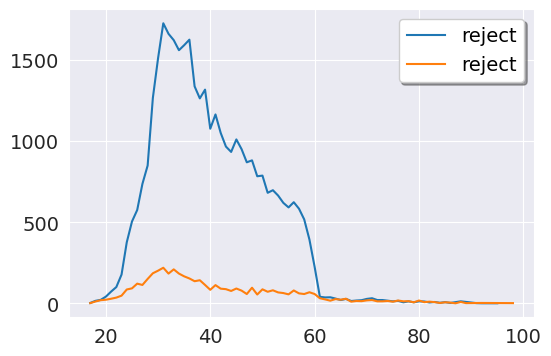

In [59]:
ax = start_plot(style='darkgrid', figsize=(6, 4))

accept_info = bank.groupby(['result', 'age']).size()
age_info = bank.groupby(['age']).size()

ax.plot(accept_info.loc[0].index,
    accept_info.loc[0], label = 'reject')
ax.plot(accept_info.loc[1].index,
    accept_info.loc[1], label = 'reject')
ax.legend(frameon=True, shadow=True,fontsize=14)

In [60]:
bank = bank[bank.loan != 'unknown']
bank = bank[bank.marital != 'unknown']
bank = bank[bank.education != 'illiterate']

dont_want = ['emp.var.rate','cons.price.idx',
    'cons.conf.idx','euribor3m','nr.employed',
    'loan', 'contact', 'duration']
bank.drop(dont_want, axis = 1, inplace = True)
bank.shape

(40101, 13)

In [61]:
%%time

y_bank = bank.result
bank = bank.drop(['result'], axis = 1)


CPU times: user 2.33 ms, sys: 959 µs, total: 3.29 ms
Wall time: 3.22 ms


In [62]:
cat_features = bank.select_dtypes(include='object').columns.tolist()
num_features = bank.select_dtypes(include=np.number).columns.tolist()

X_cat = pd.get_dummies(bank[cat_features])
X_bank = pd.concat([X_cat, bank[num_features]], axis = 1)

In [63]:
X_bank.shape

(40101, 49)

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X_bank, y_bank, test_size = 0.2,
        stratify = y_bank )
X_train.shape, y_train.shape

((32080, 49), (32080,))

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

dt = DecisionTreeClassifier()

kfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(dt, X_train, y_train, cv = kfold)

print(scores)
print(scores.mean(), scores.std())


[0.8305798  0.82870948 0.83712594 0.83665835 0.83432045]
0.8334788029925188 0.003324761003983374


## see results

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

In [67]:
models = [DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier()]

titles = ['DT',  'NB',
    'RF', 'AdaBoost', 'Gradient',
     'LightGBM', 'XGBOOST']

In [68]:
%%time

model_comp = pd.DataFrame()
cv = StratifiedKFold(n_splits=8)

for i, model in enumerate(models):
    model_comp[titles[i]] = \
        cross_val_score(model, X_train, y_train,
            scoring = 'f1_weighted', cv = cv)

[LightGBM] [Info] Number of positive: 3163, number of negative: 24907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112683 -> initscore=-2.063628
[LightGBM] [Info] Start training from score -2.063628
[LightGBM] [Info] Number of positive: 3163, number of negative: 24907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 48
[LightGBM] [Info] [bin

<Axes: >

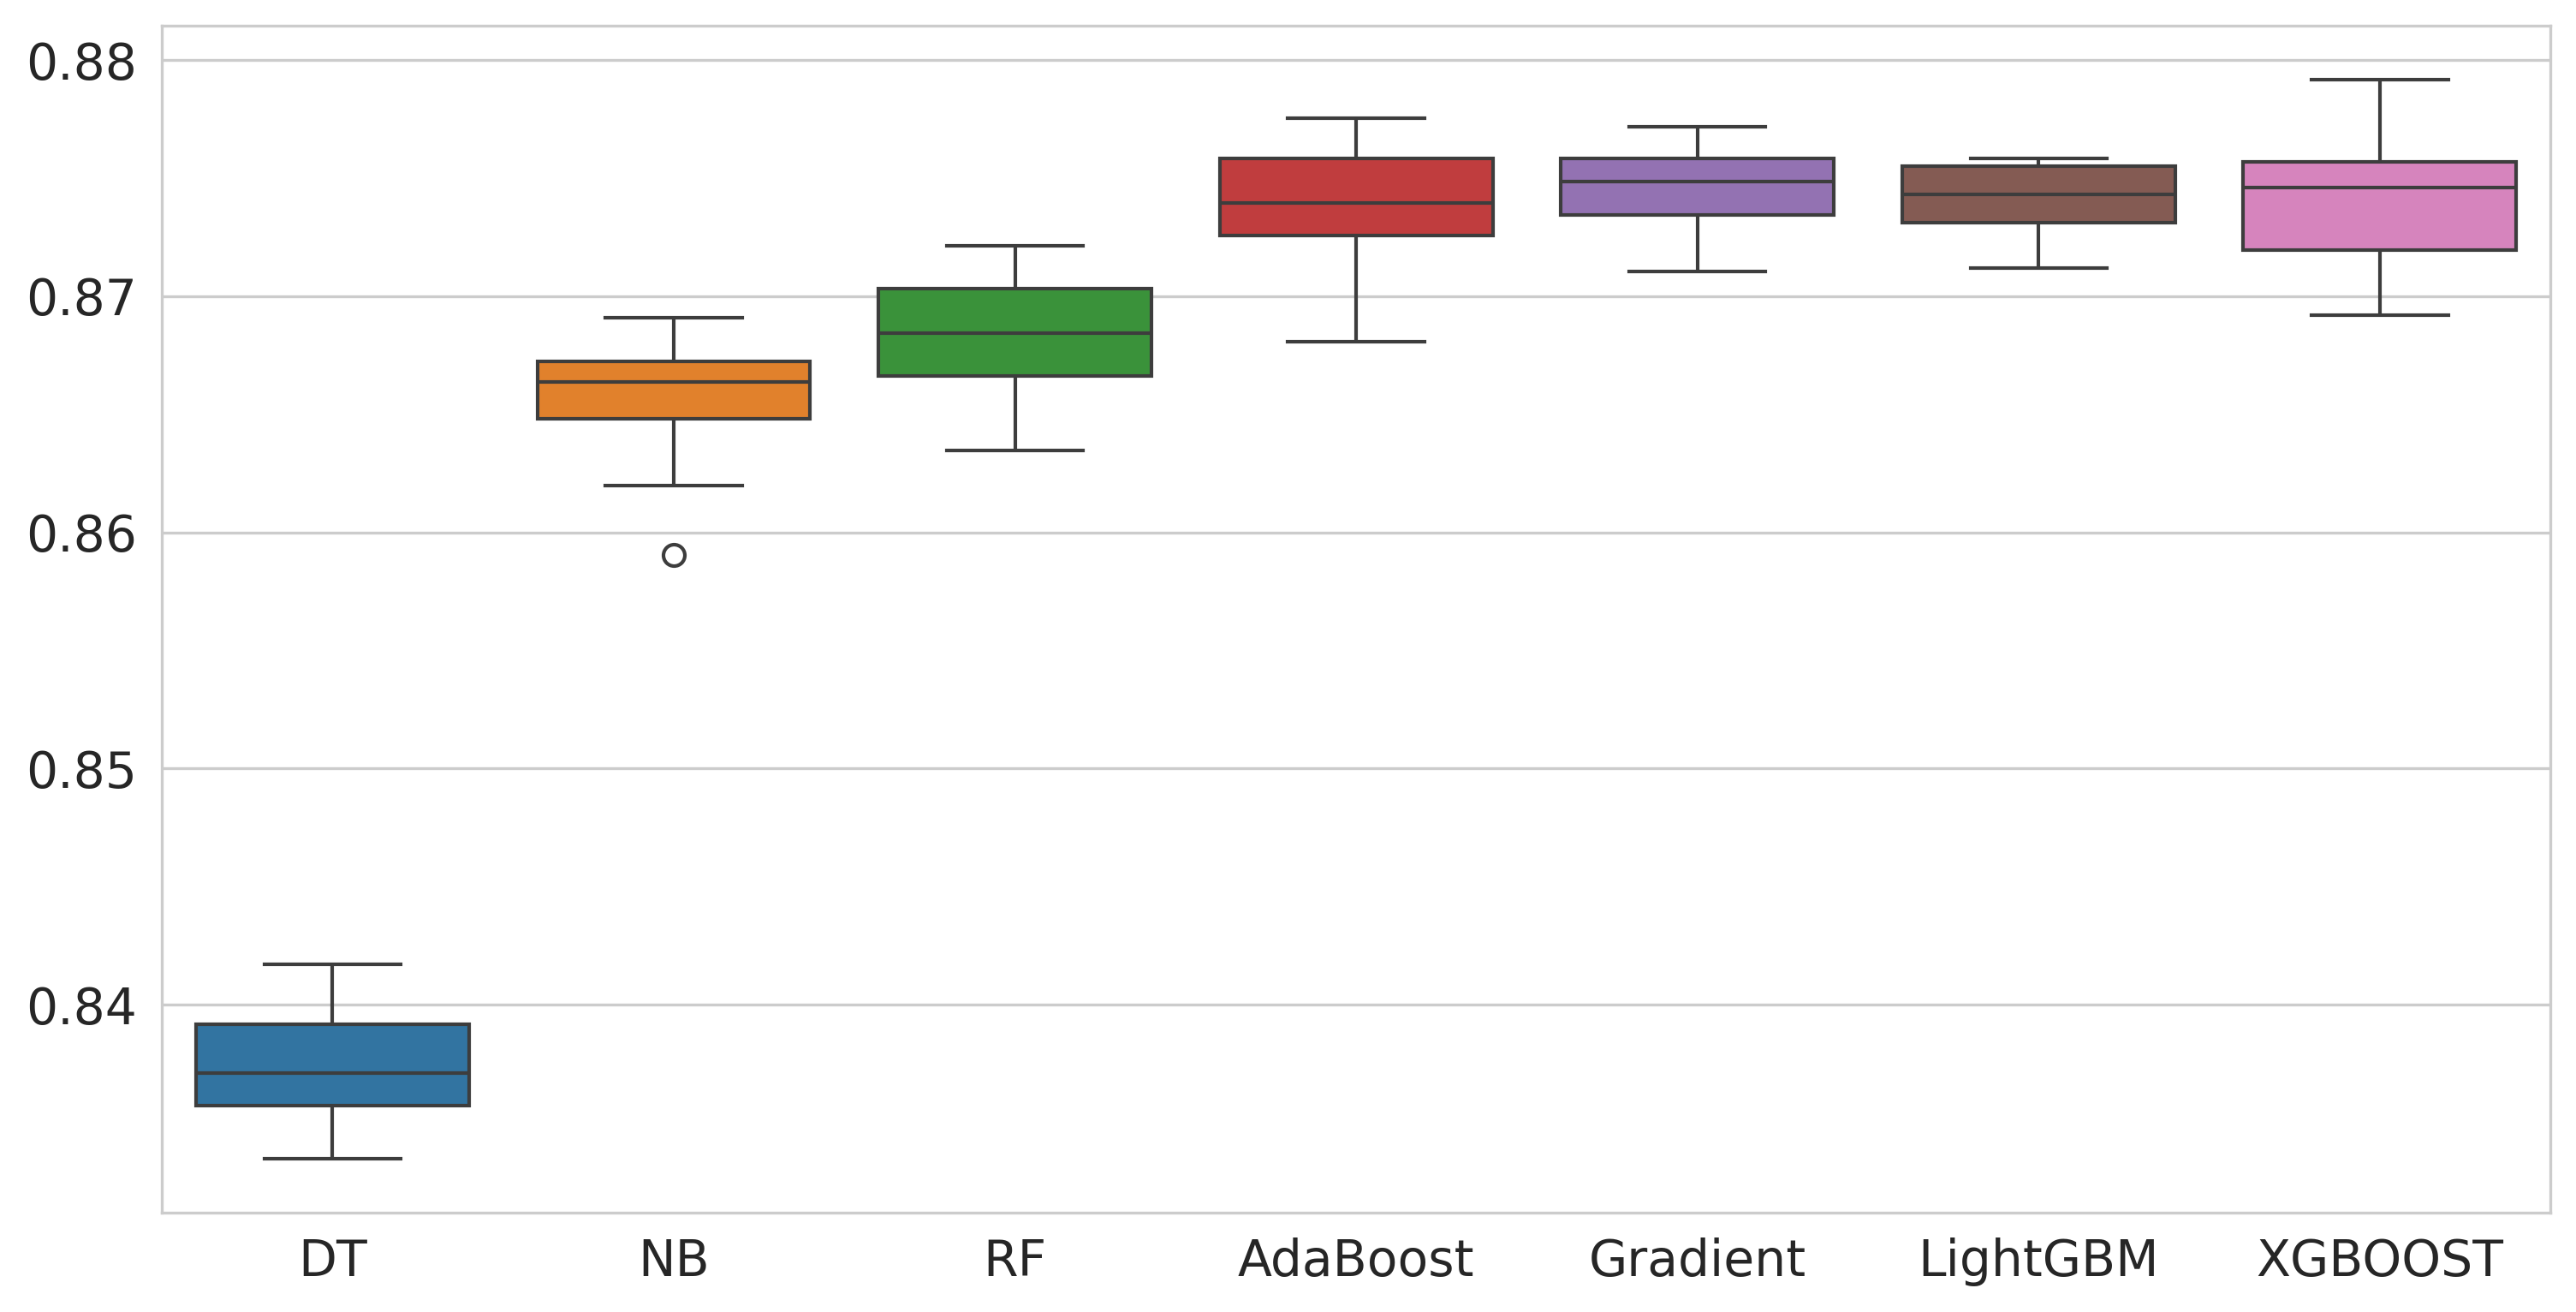

In [69]:
ax = start_plot_hires(figsize=(12,6), dpi=300)
sns.boxplot(data=model_comp, ax=ax)

## Learning Curve & Overfitting

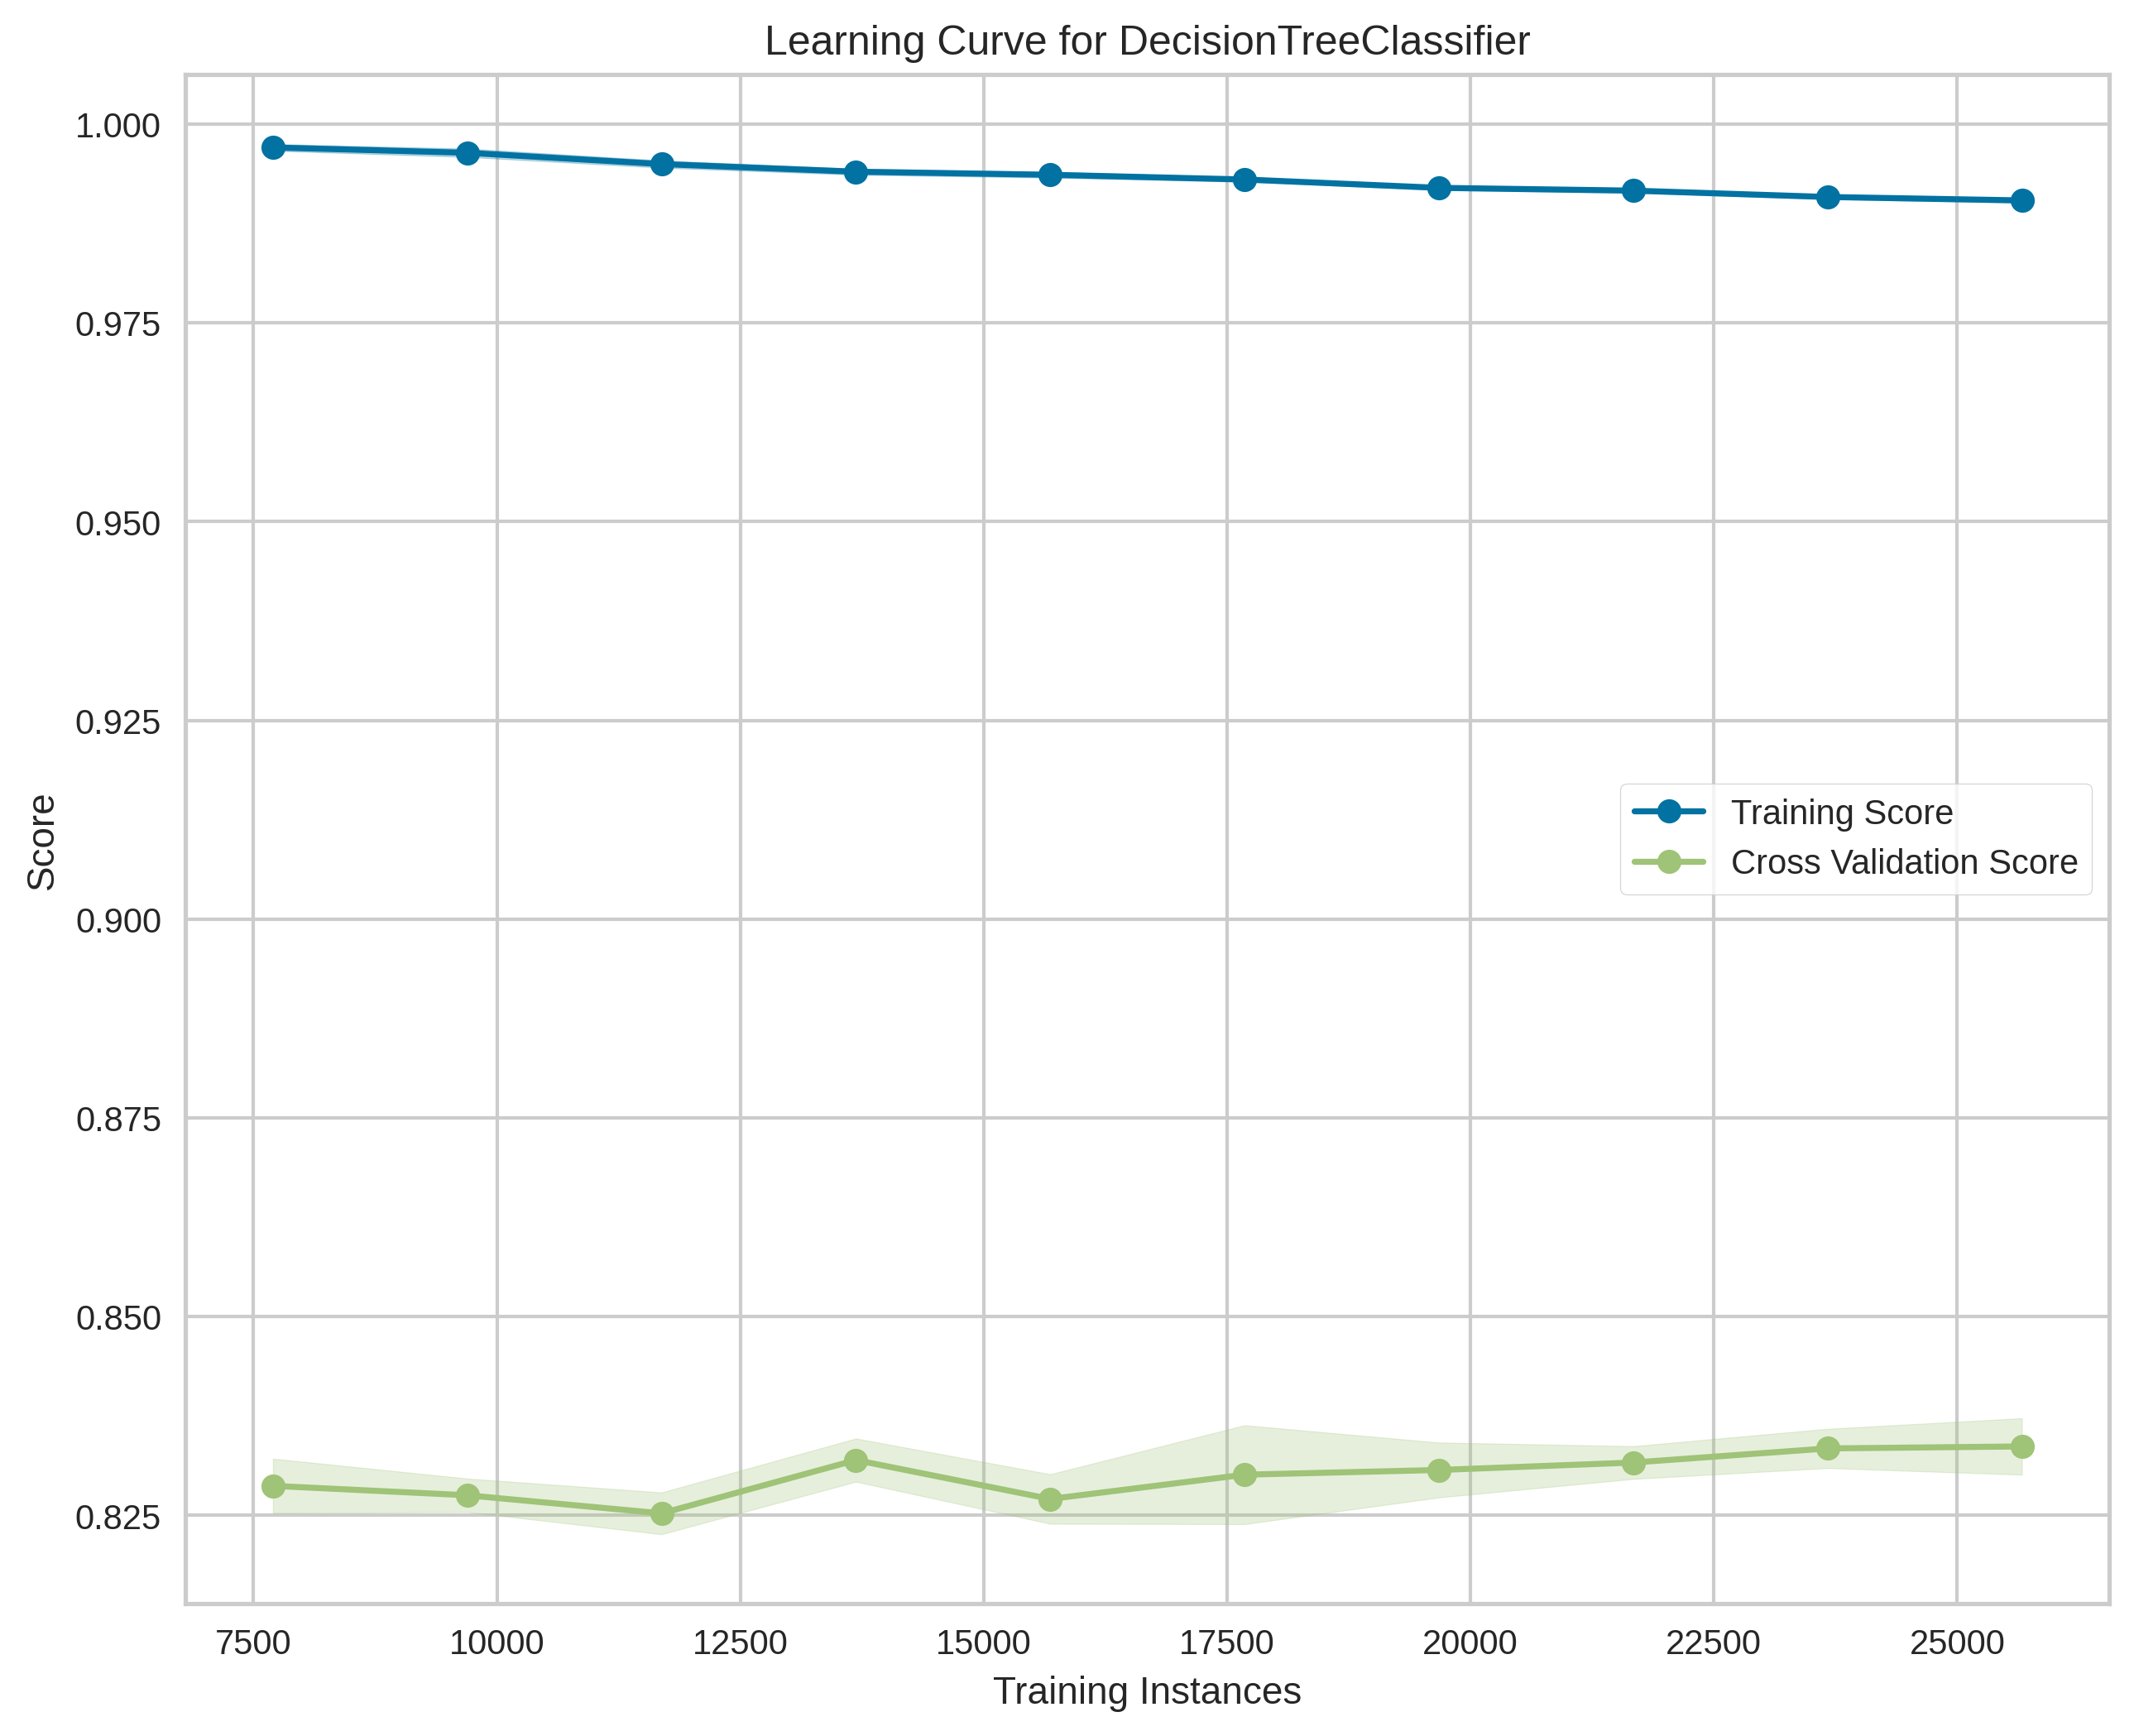

CPU times: user 7 s, sys: 74.5 ms, total: 7.07 s
Wall time: 7.13 s


<Axes: title={'center': 'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [70]:
%%time

from yellowbrick.model_selection import LearningCurve

ax = start_plot_hires(style='whitegrid')
model = DecisionTreeClassifier()
kfold = StratifiedKFold(n_splits=5)
lc = LearningCurve(
    model,
    cv = kfold,
    train_sizes= np.linspace(0.3, 1, 10)
)
lc.fit(X_train, y_train)
lc.show()


## XGBoost

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/index.html)
- [libomp problem](https://stackoverflow.com/questions/61971851/getting-this-simple-problem-while-importing-xgboost-on-jupyter-notebook)

# End of File